<a href="https://colab.research.google.com/github/sadra-barikbin/Attentionist-a-novel-solution-for-structured-sentiment-analysis/blob/main/Attentionist_SSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

This notebook is the code of the proposed solution in paper [Barikbin 2022](https://aclanthology.org/2022.semeval-1.192/).

> Please run the sections [Setup](#setup) and [Data](#data) at the first place.

<a name="setup"></a>
# Setup

In [ ]:
!pip install transformers pytorch-ignite wandb bertviz

In [ ]:
import os
import gc
import json
import torch
import wandb
import json
import warnings
import functools
import itertools
import collections
import copy
import yaml
import torch.nn.functional     as     F
import numpy                   as     np
import matplotlib.pyplot       as     plt
from  bertviz                                 import head_view
from  tabulate                                import tabulate
from  pathlib                                 import Path
from  operator                                import attrgetter, itemgetter
from  enum                                    import IntEnum
from  dataclasses                             import dataclass
from  torch                                   import Tensor
from  tqdm                                    import tqdm
from  torch.utils.data                        import DataLoader, Dataset
from  torch.utils.tensorboard                 import SummaryWriter
from  torch.nn.utils.rnn                      import pad_sequence
from  torch                                   import nn, Tensor
from  torch.optim.lr_scheduler                import StepLR
from  transformers                            import RobertaModel, RobertaTokenizerFast
from  transformers                            import PreTrainedTokenizerFast
from  transformers                            import BertModel, BertTokenizerFast
from  transformers                            import AutoTokenizer, AutoModel
from  transformers.modeling_outputs           import BaseModelOutput
from  typing                                  import Tuple, Dict, List, Any, Sequence, Union
from  typing                                  import Optional, Callable, Type
from  timeit                                  import timeit
from  ignite.metrics                          import Accuracy, Fbeta, Average
from  ignite.metrics                          import Metric, RunningAverage
from  ignite.handlers.terminate_on_nan        import TerminateOnNan
from  ignite.handlers.checkpoint              import ModelCheckpoint
from  ignite.handlers                         import EarlyStopping, global_step_from_engine
from  ignite.handlers                         import EpochOutputStore, LRScheduler
from  ignite.handlers.param_scheduler         import create_lr_scheduler_with_warmup
from  ignite.handlers.param_scheduler         import PiecewiseLinear
from  ignite.engine                           import create_supervised_trainer
from  ignite.engine                           import Engine, create_supervised_evaluator
from  ignite.engine.events                    import Events
from  ignite.contrib.handlers.tqdm_logger     import ProgressBar
from  ignite.contrib.handlers.wandb_logger    import WandBLogger

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [1]:
DATASET_NAMES_MAP = {'opener_en': 'Opener_En', 'opener_es': 'Opener_Es', 'norec': 'Norec',
                     'darmstadt_unis': 'Darmstadt_unis', 'multibooked_eu': 'Multibooked_eu',
                     'multibooked_ca': 'Multibooked_ca', 'mpqa': 'MPQA'}

You could see all of the logs, metrics and artifacts related to the experiments in thses links:

- [Ablation study](https://wandb.ai/sadra-barikbin/SSA-Attentionist-Ablation-Study)
- [Train-test discrepancy mitigation](https://wandb.ai/sadra-barikbin/SSA-Attentionist-extra-analysis)
- [Best variants](https://wandb.ai/sadra-barikbin/SSA-Attentionist-best-variants)

In [ ]:
!wandb login --cloud # %Wandb API key, taken from your account's settings%

<a name="helper_classes"></a>
# Helper Classes

In [ ]:
class TokenLabelEnum(IntEnum):

  def __new__(cls, value, tag=None):
    obj = int.__new__(cls, value)
    obj._value_ = value
    obj.tag = tag
    return obj

  @classmethod
  def from_integers(cls, integers: Sequence[int]) -> Sequence[IntEnum]:
    return [cls(integer) for integer in integers]

  @classmethod
  def from_labels(cls, labels: Sequence[IntEnum]) -> Sequence[int]:
    return [label.value for label in labels]

  def is_out(self):
    return self == self.__class__.OUT


class TokenBIOLabelEnum(TokenLabelEnum):

  def is_begin(self):
    return self % 2 == 0 and self != self.__class__.OUT

  def is_in(self):
    return self % 2 == 1

In [ ]:
class NonPolarSentExprTokenEnum(TokenBIOLabelEnum):
  EXPR_BEGIN = 0
  EXPR_IN = 1
  OUT = 2

class SentExprTokenEnum(TokenBIOLabelEnum):
  POSITIVE_EXPR_BEGIN = (0, 'Positive')
  POSITIVE_EXPR_IN = (1, 'Positive')
  NEGATIVE_EXPR_BEGIN = (2, 'Negative')
  NEGATIVE_EXPR_IN = (3, 'Negative')
  NEUTRAL_EXPR_BEGIN = (4, 'Neutral')
  NEUTRAL_EXPR_IN = (5, 'Neutral')
  OUT = 6

class SentHolderTokenEnum(TokenBIOLabelEnum):
  EXPR_BEGIN = 0
  EXPR_IN = 1
  OUT = 2


class SentTargetTokenEnum(TokenBIOLabelEnum):
  EXPR_BEGIN = 0
  EXPR_IN = 1
  OUT = 2


class ExpressionTokenEnum(TokenLabelEnum):
  SENTIMENT_POSITIVE = (0, 'Positive')
  SENTIMENT_NEUTRAL = (1, 'Neutral')
  SENTIMENT_NEGATIVE = (2, 'Negative')
  TARGET = (3, 'Target')
  HOLDER = (4, 'Holder')
  OUT = 5


In [ ]:
@dataclass
class SentimentGraphNode:

  span_in_sentence: slice
  tag: Any=None

  @property
  def span_length(self) -> int:
    return self.span_in_sentence.stop - self.span_in_sentence.start


  @property
  def indices(self) -> List[int]:
    return list(range(self.span_in_sentence.start, self.span_in_sentence.stop))

  def __hash__(self) -> int:
    return (self.span_in_sentence.start, self.span_in_sentence.stop).__hash__()


  def __eq__(self, other) -> bool:
    return self.span_in_sentence == other.span_in_sentence


@dataclass
class SentimentGraphNodeSet:
  sentiment_nodes: List[SentimentGraphNode]
  target_nodes: List[SentimentGraphNode]
  holder_nodes: List[SentimentGraphNode]

In [ ]:
@dataclass
class SentimentGraphGoldNode:
  nodes: List[SentimentGraphNode]

  def __hash__(self) -> int:
    return tuple(self.nodes).__hash__()


  def __eq__(self, other) -> bool:
    return self.nodes == other.nodes


@dataclass
class SentimentGraphGoldNodeSet:
  sentiment_nodes: List[SentimentGraphGoldNode]
  target_nodes: List[SentimentGraphGoldNode]
  holder_nodes: List[SentimentGraphGoldNode]

In [ ]:
@dataclass
class SentimentGraphEdgeSet:
  sentiment_target_edges: Tensor
  sentiment_holder_edges: Tensor

@dataclass
class SentimentGraphGoldEdgeSet:
  sentiment_target_edges: Dict[SentimentGraphGoldNode, SentimentGraphGoldNode]
  sentiment_holder_edges: Dict[SentimentGraphGoldNode, SentimentGraphGoldNode]

In [ ]:
@dataclass
class SentimentGraph:
  nodes: SentimentGraphNodeSet
  edges: SentimentGraphEdgeSet

@dataclass
class GoldSentimentGraph:
  nodes: SentimentGraphGoldNodeSet
  edges: SentimentGraphGoldEdgeSet

<a name="tokenizer"></a>
# Tokenizer

In [ ]:
@functools.lru_cache()
def get_tokenizer(dataset_name: str) -> PreTrainedTokenizerFast:
  if dataset_name in ["opener_en", "mpqa", "darmstadt_unis"]:
    return RobertaTokenizerFast.from_pretrained('roberta-base', add_prefix_space=True)
  else:
    return BertTokenizerFast.from_pretrained('setu4993/LaBSE', add_prefix_space=True)

# Config

In [ ]:
CONFIG = {
    "sequence_labeler":{
        "WEIGHTED_LOSS" : False,
    },
    "base_pooler":{
        "AVERAGE_HEADS" : False,
        "TARGET_AND_HOLDER_SEPARATE_HEAD" : True,
    },
    "mitigate_train_inference_discrepancy": True,
    "edge_predictor":{
        "USE_BIAS" : True
    },
    "dataset" : "opener_en",
    "batch_size" : 32,
    "random_seed" : 37773,
    "optimizer" : "AdamW",
    "LR" : {
        "base" : {
            "init" : 1e-4,
            "policy" : "StepLR(9,.1)",
            "warm-up" : "Linear(1e-6 -> 1e-4, 1 epoch)"
        },
        "novelty" : {
            "init" : 1e-3,
            "policy" : "StepLR(9,.1)",
            "warm-up" : "Linear(1e-5 -> 1e-3, 1 epoch)"
        }
    }
}

In [ ]:
torch.manual_seed(CONFIG["random_seed"])

<a name="data"></a>
# Data

In [ ]:
! git clone https://github.com/sadra-barikbin/semeval22_structured_sentiment.git

Cloning into 'semeval22_structured_sentiment'...
remote: Enumerating objects: 1093, done.
remote: Counting objects: 100% (199/199), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 1093 (delta 105), reused 148 (delta 71), pack-reused 894
Receiving objects: 100% (1093/1093), 17.09 MiB | 20.02 MiB/s, done.
Resolving deltas: 100% (534/534), done.


<a name="dataset_class"></a>
# Dataset Class

> Please run [Tokenizer](#tokenizer) and [Data](#data) cells first.

In [ ]:
class SemEval2022Task10Dataset(Dataset):

  def __init__(self, split: str, config: Dict[str, Any],
               path: str='semeval22_structured_sentiment/data'):
    super(SemEval2022Task10Dataset, self).__init__()

    dataset_names = ["opener_en", "opener_es", "norec", "darmstadt_unis", "mpqa",
                    "multibooked_ca", "multibooked_eu", "ALL"]

    self.config = config

    name = config["dataset"]
    assert split in ["train", "dev", "test"]
    self.split = split

    tokenizer = get_tokenizer(name)

    if name == 'ALL':
      assert split != 'test'

      data = []
      for _name in dataset_names[:-1]:
        data.extend(json.load(open(f"{path}/{_name}/{split}.json")))
    else:
      data = json.load(open(f"{path}/{name}/{split}.json"))

    if split == 'test':
      self.data = data
      return

    self.data = []

    sentim_labels_stat = collections.Counter(SentExprTokenEnum)
    target_labels_stat = collections.Counter(SentTargetTokenEnum)
    holder_labels_stat = collections.Counter(SentHolderTokenEnum)

    polarity_stat = collections.Counter()
    for sent_idx, item in enumerate(data):
      if not item['opinions']:
          continue
      if item['sent_id'] in ['multibooked/corpora/eu/kaype-quintamar-llanes_1-1',
                              'temp_fbis/21.31.56-18015-2', '20020414/21.16.03-15717-6',
                              'xbank/wsj_0583-27']:
        # These samples are erroneous
        continue

      encoded = tokenizer([item['text']], add_special_tokens=False,
                         return_offsets_mapping=True, return_length=True)
      tokens_char_offsets = encoded['offset_mapping'][0]

      length = encoded['length'][0]
      tokens_labels_sentiment = [SentExprTokenEnum.OUT] * length
      tokens_labels_target = [SentTargetTokenEnum.OUT] * length
      tokens_labels_holder = [SentHolderTokenEnum.OUT] * length

      sentiment_nodes = []
      target_nodes = []
      holder_nodes = []
      sentim_tgt_edges = {}
      sentim_hld_edges = {}

      gold_sentiment_nodes = []
      gold_target_nodes = []
      gold_holder_nodes = []
      gold_sentim_tgt_edges = {}
      gold_sentim_hld_edges = {}

      for opinion in item['opinions']:
        opinion_sentiment_nodes = []
        opinion_target_nodes = []
        opinion_holder_nodes = []

        polarity_stat.update(opinion['Polarity'])

        for char_span in opinion["Polar_expression"][1]:
          char_span_begin, char_span_end = (int(x) for x in char_span.split(':'))
          token_span_begin, token_span_end = self._char_span_to_token_span_idx(
              sent_idx, tokens_char_offsets, (char_span_begin, char_span_end)
          )
          node = SentimentGraphNode(
              slice(token_span_begin, token_span_end), opinion['Polarity']
          )
          opinion_sentiment_nodes.append(node)
          if node not in sentiment_nodes:
            sentiment_nodes.append(node)

            self._update_sequence_labels(
                sent_idx,
                tokens_labels_sentiment,
                token_span_begin,
                token_span_end,
                "sentiment",
                opinion["Polarity"]
            )

        for char_span in opinion["Target"][1]:
          char_span_begin, char_span_end = (int(x) for x in char_span.split(':'))
          token_span_begin, token_span_end = self._char_span_to_token_span_idx(
              sent_idx, tokens_char_offsets, (char_span_begin, char_span_end)
          )
          node = SentimentGraphNode(
              slice(token_span_begin, token_span_end), "target"
          )
          opinion_target_nodes.append(node)
          if node not in target_nodes:
            target_nodes.append(node)

            self._update_sequence_labels(
                sent_idx,
                tokens_labels_target,
                token_span_begin,
                token_span_end,
                "target"
            )

        for char_span in opinion["Source"][1]:
          char_span_begin, char_span_end = (int(x) for x in char_span.split(':'))
          token_span_begin, token_span_end = self._char_span_to_token_span_idx(
              sent_idx, tokens_char_offsets, (char_span_begin, char_span_end)
          )
          node = SentimentGraphNode(
              slice(token_span_begin, token_span_end), "holder"
          )
          opinion_holder_nodes.append(node)
          if node not in holder_nodes:
            holder_nodes.append(node)

            self._update_sequence_labels(
                sent_idx,
                tokens_labels_holder,
                token_span_begin,
                token_span_end,
                "holder"
            )

        for sentiment_node in opinion_sentiment_nodes:
          sentim_tgt_edges[sentiment_node] = opinion_target_nodes
          sentim_hld_edges[sentiment_node] = opinion_holder_nodes
        
        gold_sentiment_node = SentimentGraphGoldNode(opinion_sentiment_nodes)
        gold_target_node = SentimentGraphGoldNode(opinion_target_nodes)
        gold_holder_node = SentimentGraphGoldNode(opinion_holder_nodes)
        
        gold_sentiment_nodes.append(gold_sentiment_node)
        gold_target_nodes.append(gold_target_node)
        gold_holder_nodes.append(gold_holder_node)

        gold_sentim_tgt_edges[gold_sentiment_node] = gold_target_node
        gold_sentim_hld_edges[gold_sentiment_node] = gold_holder_node

      sentiment_nodes.sort(key=attrgetter("span_in_sentence"))
      target_nodes.sort(key=attrgetter("span_in_sentence"))
      holder_nodes.sort(key=attrgetter("span_in_sentence"))

      sentim_tgt_adj_matrix = torch.zeros((len(sentiment_nodes), len(target_nodes)))
      sentim_hld_adj_matrix = torch.zeros((len(sentiment_nodes), len(holder_nodes)))
      for i, sentim_node in enumerate(sentiment_nodes):

        for neighbor_tgt_node in sentim_tgt_edges[sentim_node]:
          sentim_tgt_adj_matrix[i, target_nodes.index(neighbor_tgt_node)] = 1

        for neighbor_hld_node in sentim_hld_edges[sentim_node]:
          sentim_hld_adj_matrix[i, holder_nodes.index(neighbor_hld_node)] = 1
      
      gold_node_set = SentimentGraphGoldNodeSet(gold_sentiment_nodes, gold_target_nodes,
                                                gold_holder_nodes)
      gold_edge_set = SentimentGraphGoldEdgeSet(gold_sentim_tgt_edges, gold_sentim_hld_edges)
      gold_graph = GoldSentimentGraph(gold_node_set, gold_edge_set)
      

      self.data.append({
          "sent_id": item['sent_id'],
          "text": item['text'],
          "length": length,
          "seq_labels": {
              "sentiment": tokens_labels_sentiment,
              "target": tokens_labels_target,
              "holder": tokens_labels_holder},
          "graph":SentimentGraph(
              SentimentGraphNodeSet(
                sentiment_nodes, target_nodes, holder_nodes
              ),
              SentimentGraphEdgeSet(
                sentim_tgt_adj_matrix, sentim_hld_adj_matrix
              )
          ),
          "gold_graph": gold_graph}
        )

      sentim_labels_stat.update(tokens_labels_sentiment)
      target_labels_stat.update(tokens_labels_target)
      holder_labels_stat.update(tokens_labels_holder)

    self.sentim_seq_label_weights = torch.Tensor(
        [sentim_labels_stat[label] for label in sorted(sentim_labels_stat)])
    self.sentim_seq_label_weights = self.sentim_seq_label_weights.max() / \
                                          self.sentim_seq_label_weights

    self.target_seq_label_weights = torch.Tensor(
        [target_labels_stat[label] for label in sorted(target_labels_stat)])
    self.target_seq_label_weights = self.target_seq_label_weights.max() / \
                                          self.target_seq_label_weights

    self.holder_seq_label_weights = torch.Tensor(
        [holder_labels_stat[label] for label in sorted(holder_labels_stat)])
    self.holder_seq_label_weights = self.holder_seq_label_weights.max() / \
                                          self.holder_seq_label_weights

    self.polarity_weights = torch.Tensor([polarity_stat['Positive'], polarity_stat['Neutral'],
                                          polarity_stat['Negative']])

  def _update_sequence_labels(self, sent_idx: int, sequence: List[TokenLabelEnum],
                              start_token: int, end_token: int,
                              expr_type: str, polarity: str=None):
    if expr_type == 'sentiment':
      if polarity == 'Positive':
        begin_label = SentExprTokenEnum.POSITIVE_EXPR_BEGIN
        in_label = SentExprTokenEnum.POSITIVE_EXPR_IN
      elif polarity == 'Negative':
        begin_label = SentExprTokenEnum.NEGATIVE_EXPR_BEGIN
        in_label = SentExprTokenEnum.NEGATIVE_EXPR_IN
      elif polarity == 'Neutral':
        begin_label = SentExprTokenEnum.NEUTRAL_EXPR_BEGIN
        in_label = SentExprTokenEnum.NEUTRAL_EXPR_IN
      else:
        raise ValueError("Given expr_type is 'sentiment' but 'polarity' is None.")
      out = SentExprTokenEnum.OUT
    elif expr_type == 'target':
      begin_label = SentTargetTokenEnum.EXPR_BEGIN
      in_label = SentTargetTokenEnum.EXPR_IN
      out = SentTargetTokenEnum.OUT
    elif expr_type == 'holder':
      begin_label = SentHolderTokenEnum.EXPR_BEGIN
      in_label = SentHolderTokenEnum.EXPR_IN
      out = SentHolderTokenEnum.OUT
    else:
      raise ValueError(f"Given expr_type is not recognized. expr_type={expr_type}")

    # First time I saw these warnings in MPQA dataset. They were
    # mistakes so I opened an issue. But generally such scenarios in which
    # a part of an expression is itself another expression, are acceptable.
    # So I took union of them as the final expression.
    if sequence[start_token] != out:
      warnings.warn(f"Sequence is already updated at index {start_token}, "
                    f"expr_type={expr_type}, sent_idx={sent_idx}")

      if expr_type == 'sentiment' and sequence[start_token].tag != begin_label.tag:
        warnings.warn("Two expressions with conflicting polarities"
                      f" in the same place. sent_idx={sent_idx} "
                      f"polarities={sequence[start_token].tag}-{begin_label.tag}")
    else:
      sequence[start_token] = begin_label
    for i in range(start_token + 1, end_token):
      if sequence[i] != out:
        warnings.warn(f"Sequence is already updated at index {i}, "
                      f"expr_type={expr_type}, sent_idx={sent_idx}")

        if expr_type == 'sentiment' and sequence[i].tag != in_label.tag:
          warnings.warn("Two expressions with conflicting polarities in the same place."
                        f" sent_idx={sent_idx} polarities={sequence[i].tag}-{in_label.tag}")

      sequence[i] = in_label


  def _char_span_to_token_span_idx(
      self, sent_idx: int, tokens_char_offsets: List[Tuple[int, int]],
      char_span: Tuple[int, int]) -> Tuple[int, int]:

    begin_token_idx, end_token_idx = None, None
    for i, (char_offset_begin, char_offset_end) in enumerate(tokens_char_offsets):
      if char_offset_begin == char_span[0] and begin_token_idx is None:
        begin_token_idx = i

      if char_offset_end == char_span[1] and end_token_idx is None:
        end_token_idx = i + 1

      if begin_token_idx is not None and end_token_idx is not None:
        return begin_token_idx, end_token_idx

    raise ValueError("Given char_span does not exist in given token char offsets. "
                     f"sent_idx={sent_idx} char_span={char_span} "
                     f"token_char_offsets={tokens_char_offsets}")


  def __len__(self):
    return len(self.data)


  def __getitem__(self, idx) -> Dict[str, Any] :
    item = self.data[idx]

    if self.split != 'test':
      item["label_weights"] = {"sentiment": self.sentim_seq_label_weights,
                              "target": self.target_seq_label_weights,
                              "holder": self.holder_seq_label_weights}

      item["polarity_weights"] = self.polarity_weights

    return item

<a name="model"></a>
# Model Definition

> Please run [Helper Classes](#helper_classes) section beforehand.

In SemEval2022 Task10 description, it is stated that we can see the sentiment, target and holder expressions in a sentence as a graph, which the expressions are its nodes and there is edge from a sentiment expression node to its pertaining target and holder ones.

In [ ]:
class SharedSchemeTokenClassification:

  @classmethod
  def _nstate(cls, state: str, label: Union[ExpressionTokenEnum, None], nlabel: ExpressionTokenEnum) -> str:
    if nlabel.is_out():
      return 'skipping'
    if state == 'reading':
      if nlabel != label:
        return 'start_reading'
      else:
        return 'reading'
    elif state == 'skipping':
      return 'start_reading'
    else: # state == 'start_reading'
      if nlabel != label:
        return 'start_reading'
      else:
        return 'reading'


  @classmethod
  def extract_spans(cls, token_labels: Sequence[TokenLabelEnum]) -> List[Tuple[slice, Any]]:
    state = 'skipping'
    span_start = 0
    span_length = 0
    spans = []
    label = None
    for i in range(len(token_labels)):
      nlabel = token_labels[i]
      nstate = cls._nstate(state, label, nlabel)
      if nstate == 'start_reading':
        if state == 'reading' or state == 'start_reading':
          spans.append((slice(span_start, span_start + span_length), token_labels[i-1].tag))
        span_start = i
        span_length = 1
      elif nstate == 'reading':
        span_length += 1
      else: # nstate == 'skipping'
        if state == 'reading' or state == 'start_reading':
          spans.append((slice(span_start, span_start + span_length), token_labels[i-1].tag))
      state = nstate
      label = nlabel
    if state != 'skipping':
      spans.append((slice(span_start, span_start + span_length), token_labels[i].tag))
    return spans

In [ ]:
class BIOSchemeTokenClassification:

  @classmethod
  def _nstate(cls, state: str, label: TokenBIOLabelEnum) -> str:
    if label.is_out():
      return 'skipping'
    if state == 'reading':
      if label.is_begin():
        return 'start_reading'
      else: # label.is_in()
        return 'reading'
    elif state == 'skipping':
      if label.is_begin():
        return 'start_reading'
      else:
        return 'skipping'
    else: # state == 'start_reading'
      if label.is_begin():
        return 'start_reading'
      else: # label.is_in()
        return 'reading'


  @classmethod
  def extract_spans(cls, token_labels: Sequence[TokenBIOLabelEnum]) -> List[Tuple[slice, Any]]:
    state = 'skipping'
    span_start = 0
    span_length = 0
    spans = []
    for i in range(len(token_labels)):
      label = token_labels[i]
      nstate = cls._nstate(state, label)
      if nstate == 'start_reading':
        if state == 'reading' or state == 'start_reading':
          spans.append((slice(span_start, span_start + span_length), token_labels[i-1].tag))
        span_start = i
        span_length = 1
      elif nstate == 'reading':
        span_length += 1
      else: # nstate == 'skipping'
        if state == 'reading' or state == 'start_reading':
          spans.append((slice(span_start, span_start + span_length), token_labels[i-1].tag))
      state = nstate
    if state != 'skipping':
      spans.append((slice(span_start, span_start + span_length), token_labels[i].tag))
    return spans

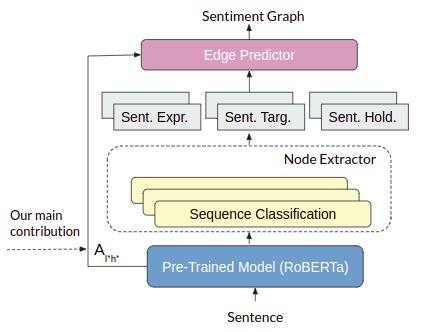

## Sequence Labeler

In [ ]:
class SequenceLabeler(nn.Module):

  def __init__(self, input_dim: int, hidden_dim: int, label_enum: TokenLabelEnum):
    super(SequenceLabeler, self).__init__()

    self.seq_label = nn.ModuleList([nn.Linear(input_dim, hidden_dim), nn.Dropout(), 
                                    nn.ReLU(), nn.Linear(hidden_dim, len(label_enum))])
    self.label_enum = label_enum


  def forward(self, ptm_output: BaseModelOutput, padding_mask: Tensor) -> Tensor:
    output = ptm_output.last_hidden_state
    for layer in self.seq_label:
      output = layer(output)
    return output


  @torch.no_grad()
  def predict(self, output: Tensor,
              padding_mask: Tensor) -> List[Sequence[TokenLabelEnum]]:
    output = torch.argmax(output, dim=2)
    batch_size = output.shape[0]
    preds_batch = []
    for i in range(batch_size):
      mask_i = padding_mask[i] == 1
      output_i = output[i]
      preds_batch.append(self.label_enum.from_integers(output_i[mask_i].cpu().numpy()))

    return preds_batch

## Node Extractor

In [ ]:
class SentimentGraphNodeExtractor(nn.Module):

  def __init__(self, config: Dict[str, Any]):
    super(SentimentGraphNodeExtractor, self).__init__()

    self.sentiment_labeler = SequenceLabeler(768, 64, SentExprTokenEnum)
    self.target_labeler = SequenceLabeler(768, 64, SentTargetTokenEnum)
    self.holder_labeler = SequenceLabeler(768, 64, SentHolderTokenEnum)


  def forward(self, ptm_output: BaseModelOutput, padding_mask: Tensor) -> Union[Tuple[Tensor, Tensor, Tensor], Tensor]:
    return (self.sentiment_labeler(ptm_output, padding_mask),
            self.target_labeler(ptm_output, padding_mask),
            self.holder_labeler(ptm_output, padding_mask))


  @torch.no_grad()
  def predict(self, output: Union[Tuple[Tensor, Tensor, Tensor], Tensor],
              padding_mask: Tensor) -> List[SentimentGraphNodeSet]:
                                                          
    sentiment_labels = self.sentiment_labeler.predict(output[0], padding_mask)
    target_labels = self.target_labeler.predict(output[1], padding_mask)
    holder_labels = self.holder_labeler.predict(output[2], padding_mask)

    batch_size = padding_mask.shape[0]
    nodes_batch = []
    for i in range(batch_size):

      sentiment_nodes = BIOSchemeTokenClassification.extract_spans(sentiment_labels[i])
      sentiment_nodes = [SentimentGraphNode(*tup) for tup in sentiment_nodes]

      target_nodes = BIOSchemeTokenClassification.extract_spans(target_labels[i])
      target_nodes = [SentimentGraphNode(*tup) for tup in target_nodes]

      holder_nodes = BIOSchemeTokenClassification.extract_spans(holder_labels[i])
      holder_nodes = [SentimentGraphNode(*tup) for tup in holder_nodes]

      nodes_batch.append(SentimentGraphNodeSet(sentiment_nodes, target_nodes,
                                               holder_nodes))
    return nodes_batch

## Edge Predictor

In [ ]:
# Originally from <https://discuss.pytorch.org/t/does-nn-sigmoid-have-bias-parameter/10561/5>
class BiasedSigmoid(nn.Module):

  def __init__(self, device=None):
    super(BiasedSigmoid, self).__init__()
    self.bias = nn.Parameter(2 * torch.rand(1, device=device) - 1)


  def forward(self, input: Tensor) -> Tensor:
    return torch.sigmoid(input + self.bias)

In [ ]:
class AttentionistSentimentGraphEdgePredictor(nn.Module):

  def __init__(self, config: Dict[str, Any]):
    super(AttentionistSentimentGraphEdgePredictor, self).__init__()

    self.tgt_hld_separate_head = config["base_pooler"]["TARGET_AND_HOLDER_SEPARATE_HEAD"]

    if self.tgt_hld_separate_head:
      if config["edge_predictor"]["USE_BIAS"]:
        self.target_edge_predictor = BiasedSigmoid()
        self.holder_edge_predictor = BiasedSigmoid()
      else:
        self.target_edge_predictor = nn.Sigmoid()
        self.holder_edge_predictor = nn.Sigmoid()
    else:
      if config["edge_predictor"]["USE_BIAS"]:
        self.edge_predictor = BiasedSigmoid()
      else:
        self.edge_predictor = nn.Sigmoid()


  def forward(self, ptm_output: BaseModelOutput,
              graphs_nodes: List[SentimentGraphNodeSet]) -> List[SentimentGraphEdgeSet]:

    if self.tgt_hld_separate_head:
        attentions_target_batch, attentions_holder_batch = ptm_output.attentions

        attentions_target_batch_e1_to_e2 = attentions_target_batch_e2_to_e1 = attentions_target_batch
        attentions_holder_batch_e1_to_e2 = attentions_holder_batch_e2_to_e1 = attentions_holder_batch
    else:
        attentions_target_batch_e1_to_e2 = attentions_target_batch_e2_to_e1 = ptm_output.attentions
        attentions_holder_batch_e1_to_e2 = attentions_holder_batch_e2_to_e1 = ptm_output.attentions

    batch_size = len(graphs_nodes)
    graphs_edge_probs = []
    for i in range(batch_size):
      attentions_target_e1_to_e2 = attentions_target_batch_e1_to_e2[i]
      attentions_target_e2_to_e1 = attentions_target_batch_e2_to_e1[i]

      attentions_holder_e1_to_e2 = attentions_holder_batch_e1_to_e2[i]
      attentions_holder_e2_to_e1 = attentions_holder_batch_e2_to_e1[i]

      graph_nodes = graphs_nodes[i]

      sentim_tgt_edges = []
      for sentim_node, tgt_node in itertools.product(graph_nodes.sentiment_nodes,
                                                     graph_nodes.target_nodes):
        sentim_tgt_edges.append(
            attentions_target_e1_to_e2[sentim_node.span_in_sentence, tgt_node.span_in_sentence].sum() + \
            attentions_target_e2_to_e1[tgt_node.span_in_sentence, sentim_node.span_in_sentence].sum()
        )
      if len(sentim_tgt_edges) == 0:
        sentim_tgt_edges = None
      else:
        sentim_tgt_edges = torch.stack(sentim_tgt_edges).view(len(graph_nodes.sentiment_nodes),
                                                              len(graph_nodes.target_nodes))
        if self.tgt_hld_separate_head:
          sentim_tgt_edges = self.target_edge_predictor(sentim_tgt_edges)
        else:
          sentim_tgt_edges = self.edge_predictor(sentim_tgt_edges)

      sentim_hld_edges = []
      for sentim_node, hld_node in itertools.product(graph_nodes.sentiment_nodes,
                                                     graph_nodes.holder_nodes):
        sentim_hld_edges.append(
            attentions_holder_e1_to_e2[sentim_node.span_in_sentence, hld_node.span_in_sentence].sum() + \
            attentions_holder_e2_to_e1[hld_node.span_in_sentence, sentim_node.span_in_sentence].sum()
        )
      if len(sentim_hld_edges) == 0:
        sentim_hld_edges = None
      else:  
        sentim_hld_edges = torch.stack(sentim_hld_edges).view(len(graph_nodes.sentiment_nodes),
                                                            len(graph_nodes.holder_nodes))
        if self.tgt_hld_separate_head:
          sentim_hld_edges = self.holder_edge_predictor(sentim_hld_edges)
        else:
          sentim_hld_edges = self.edge_predictor(sentim_hld_edges)

      graphs_edge_probs.append(SentimentGraphEdgeSet(sentim_tgt_edges, sentim_hld_edges))

    return graphs_edge_probs


  @torch.no_grad()
  def predict(self, output: List[SentimentGraphEdgeSet]) -> List[SentimentGraphEdgeSet]:
    edges = []
    for graph_E in output:
      tgt_edges = graph_E.sentiment_target_edges
      tgt_edges = tgt_edges.round().int() if tgt_edges is not None else None

      hld_edges = graph_E.sentiment_holder_edges
      hld_edges = hld_edges.round().int() if hld_edges is not None else None

      edges.append(SentimentGraphEdgeSet(tgt_edges, hld_edges))

    return edges


## Model Base - RoBERTa | LaBSE

In [ ]:
class ModelBase(nn.Module):

  def __init__(self, config: Dict[str, Any]):
    super(ModelBase, self).__init__()

    if config["dataset"] in ['opener_en', 'mpqa', 'darmstadt_unis']:
      self.ptm = RobertaModel.from_pretrained('roberta-base', output_attentions=True,
                                              add_pooling_layer=False,)
    else:
      self.ptm = BertModel.from_pretrained('setu4993/LaBSE',
                                           output_attentions=True, add_pooling_layer=False)


  def forward(self, ptm_input: Dict[str, Any]) -> BaseModelOutput:
    ptm_output = self.ptm(**ptm_input)

    if not ptm_output.attentions:
      raise ValueError(
          "Attentions should be included in model input. You might have forgotten "
          "to set `output_attentions=True` on constructing PTM or calling it."
      )

    return ptm_output

## Base Pooler

In [ ]:
class BasePooler(nn.Module):

  def __init__(self, config: Dict[str, Any]):
    super(BasePooler, self).__init__()

    self.avg_heads = config["base_pooler"]["AVERAGE_HEADS"]
    self.tgt_hld_separate_head = config["base_pooler"]["TARGET_AND_HOLDER_SEPARATE_HEAD"]

    self.dataset = config["dataset"]

    if self.avg_heads:
      if self.tgt_hld_separate_head:
        initial_attention_weights_target = torch.zeros(12, 12).float()
        initial_attention_weights_holder = torch.zeros(12, 12).float()

        if self.dataset in ['opener_en', 'mpqa', 'darmstadt_unis']:
          initial_attention_weights_target[7, 6] = 1.
          initial_attention_weights_holder[10, 9] = 1.
        else:
          initial_attention_weights_target[10, 8] = 1.
          initial_attention_weights_holder[10, 3] = 1.

        self.attention_weights_target = nn.Parameter(initial_attention_weights_target)
        self.attention_weights_holder = nn.Parameter(initial_attention_weights_holder)
      else:
        initial_attention_weights = torch.zeros(12, 12).float()

        if self.dataset in ['opener_en', 'mpqa', 'darmstadt_unis']:
          initial_attention_weights[7, 6] = 1.
        else:
          initial_attention_weights[10, 8] = 1.

        self.attention_weights = nn.Parameter(initial_attention_weights)


  def forward(self, ptm_output: BaseModelOutput) -> BaseModelOutput:

    ptm_output.last_hidden_state = ptm_output.last_hidden_state[:, 1:-1, :] # Excluding CLS,SEP

    if not self.avg_heads:
      if not self.tgt_hld_separate_head:
        if self.dataset in ['opener_en', 'mpqa', 'darmstadt_unis']:
          ptm_output.attentions = ptm_output.attentions[7][:, 6] # Head 7 (pink) of layer 8
        else:
          ptm_output.attentions = ptm_output.attentions[10][:, 8] # Head 9 (green) of layer 11
      else:
        if self.dataset in ['opener_en', 'mpqa', 'darmstadt_unis']:
          ptm_output.attentions = [ptm_output.attentions[7][:, 6],# Head 7 (pink) of layer 8
                                  ptm_output.attentions[10][:, 9]]# Head 10 of layer 11
        else:
          ptm_output.attentions = [ptm_output.attentions[10][:, 8],# Head 9 (green) of layer 11
                                  ptm_output.attentions[10][:, 3]]# Head 4 (green) of layer 11
    else:
      if not self.tgt_hld_separate_head:
        ptm_output.attentions = torch.tensordot(torch.stack(ptm_output.attentions),
                                                self.attention_weights, dims=([0,2],[0,1]))
      else:
        ptm_output.attentions = [torch.tensordot(torch.stack(ptm_output.attentions),
                                                self.attention_weights_target,
                                                 dims=([0,2],[0,1])),
                                 torch.tensordot(torch.stack(ptm_output.attentions),
                                                self.attention_weights_holder,
                                                 dims=([0,2],[0,1]))]
      # Alternatively:
      # ptm_output.attentions = torch.einsum(
      #     'lbhmn, lh -> bmn', torch.stack(ptm_output.attentions), self.attention_weights
      # )
    
    # Excluding CLS,SEP
    if isinstance(ptm_output.attentions, list):
      ptm_output.attentions = [item[:, 1:-1, 1:-1] for item in ptm_output.attentions]
    else:
      ptm_output.attentions = ptm_output.attentions[:, 1:-1, 1:-1] 

    return ptm_output

## Whole Model

In [ ]:
class StructuredSentimentPredictor(nn.Module):

  def __init__(self, config: Dict[str, Any]):
    super(StructuredSentimentPredictor, self).__init__()

    self.base = ModelBase(config)

    self.novelty = nn.ModuleDict({'base_pooler': BasePooler(config),
                                  'edge_predictor': AttentionistSentimentGraphEdgePredictor(config),
                                  'node_extractor': SentimentGraphNodeExtractor(config)})

  @dataclass
  class Output:
    node_extractor_output: Union[Tuple[Tensor, Tensor, Tensor], Tensor]
    edge_predictor_output: List[SentimentGraphEdgeSet]


  def forward(self, inputs: Dict[str, Any]) -> Output:

    base_output = self.base(inputs["ptm_input"])

    base_output = self.novelty['base_pooler'](base_output)

    node_extractor_out = self.novelty['node_extractor'](base_output, inputs["padding_mask"])

    graphs_nodes = inputs["teacher_graphs_nodes"]
    edge_predictor_out = self.novelty['edge_predictor'](base_output, graphs_nodes)

    return StructuredSentimentPredictor.Output(
        node_extractor_out,
        edge_predictor_out
    )


  @torch.no_grad()
  def predict(self, inputs: Dict[str, Any], output: Output) -> List[SentimentGraph]:

    graphs_nodes = self.novelty['node_extractor'].predict(
      output.node_extractor_output, inputs['padding_mask'])

    base_output = self.base(inputs["ptm_input"])
    base_output = self.novelty['base_pooler'](base_output)

    graphs_edges_probs = self.novelty['edge_predictor'](base_output, graphs_nodes)
    graphs_edges = self.novelty['edge_predictor'].predict(graphs_edges_probs)

    return [SentimentGraph(graph_nodes, graph_edges) for graph_nodes,
            graph_edges in zip(graphs_nodes, graphs_edges)]


# Loss functions

## Node Extractor Loss

In [ ]:
def node_extractor_loss(y_pred: StructuredSentimentPredictor.Output,
                        y: Dict[str,Any], weighted=False) -> torch.double:
  sentim_labels_pred, tgt_labels_pred, hld_labels_pred = y_pred.node_extractor_output
  sentim_labels, tgt_labels, hld_labels = y['seq_labels']

  sentim_labels_loss = F.cross_entropy(
      sentim_labels_pred.permute(0, 2, 1), sentim_labels,
      ignore_index=-1, weight=y["seq_label_weights"]["sentiment"] if weighted else None)
  tgt_labels_loss = F.cross_entropy(
      tgt_labels_pred.permute(0, 2, 1), tgt_labels,
      ignore_index=-1, weight=y["seq_label_weights"]["target"] if weighted else None)
  hld_labels_loss = F.cross_entropy(
      hld_labels_pred.permute(0, 2, 1), hld_labels,
      ignore_index=-1, weight=y["seq_label_weights"]["holder"] if weighted else None)

  return sentim_labels_loss + tgt_labels_loss + hld_labels_loss

## Edge Extractor Loss - Binary Cross Entropy

In [ ]:
def edge_extractor_loss(y_pred: StructuredSentimentPredictor.Output,
                        y: Dict[str,Any]) -> torch.double:
  adj_matrices_pred_batch: List[SentimentGraphEdgeSet] = y_pred.edge_predictor_output
  adj_matrices_batch: List[SentimentGraphEdgeSet] = y["graphs_edges"]

  loss = torch.zeros((), device=DEVICE)

  for edges_pred, edges in zip(adj_matrices_pred_batch, adj_matrices_batch):

    target_edges_pred = edges_pred.sentiment_target_edges
    target_edges = edges.sentiment_target_edges
    if target_edges_pred is not None:
      loss += F.binary_cross_entropy(target_edges_pred, target_edges)

    holder_edges_pred = edges_pred.sentiment_holder_edges
    holder_edges = edges.sentiment_holder_edges
    if holder_edges_pred is not None:
      loss += F.binary_cross_entropy(holder_edges_pred, holder_edges)

  return loss

## Total Loss

In [ ]:
def loss_fn(y_pred: StructuredSentimentPredictor.Output,
                        y: Dict[str,Any], config: Dict[str, Any]) -> torch.double:

  return node_extractor_loss(y_pred, y, weighted=config["sequence_labeler"]["WEIGHTED_LOSS"]) + \
         edge_extractor_loss(y_pred, y)

# Train & Evaluation

In [ ]:
train_ds = SemEval2022Task10Dataset('train', CONFIG)
dev_ds = SemEval2022Task10Dataset('dev', CONFIG)

## Data Loaders

In [ ]:
def perturb_span(start: int, stop: int, length: int) -> Tuple[int, int]:
  offsets = np.random.permutation([-3, -2, -1, 0, 1, 2, 3])
  for offset in offsets:
    start += offset
    if start >= 0 and start < stop:
      break
    else:
      start -= offset
  
  offsets = np.random.permutation([-3, -2, -1, 0, 1, 2, 3])
  for offset in offsets:
    stop += offset
    if stop <= length and stop > start:
      break
    else:
      stop -= offset
  
  return start, stop

In [ ]:
def collate_fn(
    batch: List[Dict[str, Any]],
    tokenizer: RobertaTokenizerFast,
    config: Dict[str, Any],
    setting: str
) -> Dict[str, Any]:

  texts = [item['text'] for item in batch]
  ptm_input = tokenizer(texts, padding=True, return_tensors='pt')
  
  ptm_input_without_special_tokens = tokenizer(
      texts,
      padding=True,
      return_tensors='pt',
      add_special_tokens=False
  )

  padding_mask = ptm_input_without_special_tokens["attention_mask"]

  sentim_labels = pad_sequence([torch.LongTensor(
      SentExprTokenEnum.from_labels(item["seq_labels"]["sentiment"])
      ) for item in batch], batch_first=True, padding_value=-1)
  target_labels = pad_sequence([torch.LongTensor(
      SentTargetTokenEnum.from_labels(item["seq_labels"]["target"])
      ) for item in batch], batch_first=True, padding_value=-1)
  holder_labels = pad_sequence([torch.LongTensor(
      SentHolderTokenEnum.from_labels(item["seq_labels"]["holder"])
      ) for item in batch], batch_first=True, padding_value=-1)

  seq_labels = (sentim_labels, target_labels, holder_labels)

  graphs_edges = [item["graph"].edges for item in batch]

  if config['mitigate_train_inference_discrepancy'] and setting == 'train':

    graphs_nodes: List[SentimentGraphNodeSet] = []
    for item in batch:
      graph_nodes: SentimentGraphNodeSet = item['graph'].nodes
      length: int = item['length']

      perturbed_sentiment_nodes: List[SentimentGraphNode] = []
      for node in graph_nodes.sentiment_nodes:
        start, stop = node.span_in_sentence.start, node.span_in_sentence.stop
        assert start < stop

        perturbed_sentiment_nodes.append(
            SentimentGraphNode(slice(*perturb_span(start, stop, length)), node.tag)
        )
      
      perturbed_target_nodes: List[SentimentGraphNode] = []
      for node in graph_nodes.target_nodes:
        start, stop = node.span_in_sentence.start, node.span_in_sentence.stop
        assert start < stop

        perturbed_target_nodes.append(
            SentimentGraphNode(slice(*perturb_span(start, stop, length)), node.tag)
        )
      
      perturbed_holder_nodes: List[SentimentGraphNode] = []
      for node in graph_nodes.holder_nodes:
        start, stop = node.span_in_sentence.start, node.span_in_sentence.stop
        assert start < stop

        perturbed_holder_nodes.append(
            SentimentGraphNode(slice(*perturb_span(start, stop, length)), node.tag)
        )
      
      graphs_nodes.append(
          SentimentGraphNodeSet(
              perturbed_sentiment_nodes, perturbed_target_nodes, perturbed_holder_nodes
          )
      )
  else:
    graphs_nodes: List[SentimentGraphNodeSet] = [item["graph"].nodes for item in batch]

  gold_graphs = [item["gold_graph"] for item in batch]

  return {"seq_labels": seq_labels,
          "seq_label_weights": batch[0]["label_weights"],
          "teacher_graphs_nodes": graphs_nodes, "graphs_edges": graphs_edges,
          "ptm_input": ptm_input, "padding_mask": padding_mask,
          "polarity_weights": batch[0]["polarity_weights"],
          "gold_graphs": gold_graphs}


In [ ]:
train_dataloader = DataLoader(
    train_ds,
    collate_fn=functools.partial(
        collate_fn,
        tokenizer=get_tokenizer(CONFIG["dataset"]),
        config=CONFIG,
        setting='train'
    ),
    batch_size=CONFIG["batch_size"]
)

dev_dataloader = DataLoader(
    dev_ds,
    collate_fn=functools.partial(
        collate_fn,
        tokenizer=get_tokenizer(CONFIG["dataset"]),
        config=CONFIG,
        setting='eval'
    ),
    batch_size= CONFIG["batch_size"] * 2
)

## Model & Optimizer construction

In [ ]:
torch.cuda.empty_cache()

In [ ]:
model = StructuredSentimentPredictor(CONFIG).to(DEVICE)

optimizer_parameter_groups = [
  {'params': list(model.base.parameters())},
  {'params': list(model.novelty.parameters())}
]
optimizer = torch.optim.AdamW(optimizer_parameter_groups)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Engines

In [ ]:
def prepare_batch(
    batch: Dict[str, Any],
    device=DEVICE,
    non_blocking=True
    ) -> Tuple[Dict[str, Any], Dict[str, Any]]:
  
  padding_mask = batch["padding_mask"].to(device, non_blocking=non_blocking)

  x = {
      "ptm_input": {
           "attention_mask": batch["ptm_input"]["attention_mask"].to(
               device,
               non_blocking=non_blocking),
            "input_ids": batch["ptm_input"]["input_ids"].to(
                device,
                non_blocking=non_blocking)
            },
       "teacher_graphs_nodes": batch["teacher_graphs_nodes"],
       "padding_mask": padding_mask
       }

  if isinstance(batch["seq_labels"], torch.Tensor):
    seq_labels = batch["seq_labels"].to(device, non_blocking=non_blocking)
    seq_label_weights = batch["seq_label_weights"].to(device, non_blocking=non_blocking)
  else:
    seq_labels = tuple(tensor.to(device,
          non_blocking=non_blocking) for tensor in batch["seq_labels"])
    seq_label_weights = {k: v.to(device,
           non_blocking=non_blocking) for k,v in batch["seq_label_weights"].items()
           }
  y = {
      "seq_labels": seq_labels,
       "gold_graphs": batch["gold_graphs"],
       "graphs_edges": [SentimentGraphEdgeSet(
           item.sentiment_target_edges.to(device, non_blocking=non_blocking),
           item.sentiment_holder_edges.to(device, non_blocking=non_blocking)
           ) for item in batch["graphs_edges"]
           ],
       "padding_mask": padding_mask,
       "seq_label_weights": seq_label_weights,
       "polarity_weights": batch["polarity_weights"].to(device, non_blocking=non_blocking),
       }

  return x, y

> `y_pred_raw` is used for measuring loss during evaluation

In [ ]:
def train_output_transform(
    x: Dict[str, Any],
    y: Dict[str, Any],
    y_pred: StructuredSentimentPredictor.Output,
    loss: Tensor
    ) -> Dict[str, Any]:

  return {"y": y, "y_pred_raw": y_pred, "loss": loss.item()}

In [ ]:
def evaluate_output_transform(
    x: Dict[str, Any],
    y: Dict[str, Any],
    y_pred: StructuredSentimentPredictor.Output,
    model: nn.Module
    ) -> Dict[str, Any]:

  return {"y": y, "y_pred_raw": y_pred, "y_pred": model.predict(x, y_pred)}

In [ ]:
trainer = create_supervised_trainer(
    model, optimizer, functools.partial(loss_fn, config=CONFIG),
    deterministic=True, device=DEVICE,
    prepare_batch=prepare_batch, output_transform=train_output_transform
    )

evaluator = create_supervised_evaluator(
    model, prepare_batch=prepare_batch,
    device=DEVICE, output_transform=functools.partial(evaluate_output_transform, model=model)
    )

train_evaluator = create_supervised_evaluator(
    model, prepare_batch=prepare_batch,
    device=DEVICE, output_transform=functools.partial(evaluate_output_transform, model=model)
    )

## Metrics

In [ ]:
class MatchLogicBase:
  def is_match(self, sentim_overlap: int, target_overlap: int, holder_overlap: int,
               is_polarity_matched: bool) -> bool:
    ...


  def weighted_match(self,
                     sentim_nodes: List[SentimentGraphNode],
                     target_neighbors: List[SentimentGraphNode],
                     holder_neighbors: List[SentimentGraphNode],
                     sentim_overlap: int, target_overlap: int, holder_overlap: int,
                     ) -> float:
    ...


  def _union_length(self, nodes: List[SentimentGraphNode]) -> int:
    if len(nodes) == 0:
      return 1
    return len(set(itertools.chain(*map(attrgetter('indices'), nodes))))

In [ ]:
class GraphMatchLogic(MatchLogicBase):

  def __init__(self, keep_polarity: bool=True):
    self.keep_polarity = keep_polarity


  def is_match(self, sentim_overlap: int, target_overlap: int, holder_overlap: int,
               is_polarity_matched: bool) -> bool:
    return sentim_overlap > 0 and target_overlap > 0 and holder_overlap > 0 and \
              (is_polarity_matched or not self.keep_polarity)


  def weighted_match(self,
                     sentim_nodes: List[SentimentGraphNode],
                     target_neighbors: List[SentimentGraphNode],
                     holder_neighbors: List[SentimentGraphNode],
                     sentim_overlap: int, target_overlap: int, holder_overlap: int,
                     ) -> float:
    return (sentim_overlap / float(self._union_length(sentim_nodes)) + \
            target_overlap / float(self._union_length(target_neighbors)) + \
            holder_overlap / float(self._union_length(holder_neighbors))
            ) / 3.

In [ ]:
class SentimentMatchLogic(MatchLogicBase):

  def __init__(self, keep_polarity: bool=True):
    self.keep_polarity = keep_polarity


  def is_match(self, sentim_overlap: int, target_overlap: int, holder_overlap: int,
               is_polarity_matched: bool) -> bool:
    return sentim_overlap > 0 and (is_polarity_matched or not self.keep_polarity)


  def weighted_match(self,
                     sentim_nodes: List[SentimentGraphNode],
                     target_neighbors: List[SentimentGraphNode],
                     holder_neighbors: List[SentimentGraphNode],
                     sentim_overlap: int, target_overlap: int, holder_overlap: int,
                     ) -> float:
    return sentim_overlap / float(self._union_length(sentim_nodes)) 

In [ ]:
class TargetMatchLogic(MatchLogicBase):
  def is_match(self, sentim_overlap: int, target_overlap: int, holder_overlap: int,
               is_polarity_matched: bool) -> bool:
    return target_overlap > 0


  def weighted_match(self,
                     sentim_nodes: List[SentimentGraphNode],
                     target_neighbors: List[SentimentGraphNode],
                     holder_neighbors: List[SentimentGraphNode],
                     sentim_overlap: int, target_overlap: int, holder_overlap: int,
                     ) -> float:
    return target_overlap / float(self._union_length(target_neighbors)) 

In [ ]:
class HolderMatchLogic(MatchLogicBase):
  def is_match(self, sentim_overlap: int, target_overlap: int, holder_overlap: int,
               is_polarity_matched: bool) -> bool:
    return holder_overlap > 0


  def weighted_match(self,
                     sentim_nodes: List[SentimentGraphNode],
                     target_neighbors: List[SentimentGraphNode],
                     holder_neighbors: List[SentimentGraphNode],
                     sentim_overlap: int, target_overlap: int, holder_overlap: int,
                     ) -> float:
    return holder_overlap / float(self._union_length(holder_neighbors)) 

In [ ]:
class MetricBase(Metric):

  def __init__(self, match_logic: MatchLogicBase, weighted=True, output_transform=lambda x:x):
    self.weighted = weighted
    self.match_logic = match_logic

    super(MetricBase, self).__init__(output_transform=output_transform)


  def extract_sentim_nodes_neighbors(
    self, graph: SentimentGraph) -> List[Tuple[List[SentimentGraphNode], ...]]:
    edges_sentim_tgt = graph.edges.sentiment_target_edges
    if edges_sentim_tgt is not None:
      edges_sentim_tgt = edges_sentim_tgt.detach().cpu()

    edges_sentim_hld = graph.edges.sentiment_holder_edges
    if edges_sentim_hld is not None:
      edges_sentim_hld = edges_sentim_hld.detach().cpu()

    sentim_nodes_neighbors = []
    for i, sentim_node in enumerate(graph.nodes.sentiment_nodes):
      assert sentim_node.tag is not None

      if edges_sentim_tgt is not None:
        target_neighbors = [
          graph.nodes.target_nodes[j] for j in edges_sentim_tgt[i].nonzero()]
      else:
        target_neighbors = []

      if edges_sentim_hld is not None:
        holder_neighbors = [
          graph.nodes.holder_nodes[j] for j in edges_sentim_hld[i].nonzero()]
      else:
        holder_neighbors = []

      sentim_nodes_neighbors.append((target_neighbors, holder_neighbors))

    return sentim_nodes_neighbors


  def node_neighbors_overlap_length(self, nodes1: List[SentimentGraphNode],
                      nodes2: List[SentimentGraphNode]) -> int:
    if len(nodes1) == 0 and len(nodes2) == 0:
      return 1

    return len(set(itertools.chain(*map(attrgetter('indices'), nodes1))).intersection(
        set(itertools.chain(*map(attrgetter('indices'), nodes2)))
    ))


  def update(self, output: Tuple[List[SentimentGraph], List[GoldSentimentGraph]]):

    y_pred, y = output

    for p_graph, g_graph in zip(y_pred, y):

      p_nodes_neighbors = self.extract_sentim_nodes_neighbors(p_graph)

      intersect_matrix = torch.zeros((len(p_graph.nodes.sentiment_nodes),
                                         len(g_graph.nodes.sentiment_nodes)), dtype=int)

      weighted_intersect_matrix_for_p = torch.zeros(len(p_graph.nodes.sentiment_nodes),
                                        len(g_graph.nodes.sentiment_nodes))
      weighted_intersect_matrix_for_g = torch.zeros(len(g_graph.nodes.sentiment_nodes),
                                        len(p_graph.nodes.sentiment_nodes))

      for i, p_sentim_node in enumerate(p_graph.nodes.sentiment_nodes):
        for j, g_sentim_node in enumerate(g_graph.nodes.sentiment_nodes):

          p_target_neighbors, p_holder_neighbors = p_nodes_neighbors[i]

          g_target_neighbors = g_graph.edges.sentiment_target_edges[g_sentim_node].nodes
          g_holder_neighbors = g_graph.edges.sentiment_holder_edges[g_sentim_node].nodes

          sentim_overlap = self.node_neighbors_overlap_length([p_sentim_node], g_sentim_node.nodes)
          target_overlap = self.node_neighbors_overlap_length(p_target_neighbors, g_target_neighbors)
          holder_overlap = self.node_neighbors_overlap_length(p_holder_neighbors, g_holder_neighbors)

          if self.match_logic.is_match(sentim_overlap, target_overlap, holder_overlap,
                                       g_sentim_node.nodes[0].tag == p_sentim_node.tag):
          
            intersect_matrix[i, j] = 1

            if self.weighted:
              weighted_intersect_matrix_for_p[i, j] = \
                self.match_logic.weighted_match([p_sentim_node], p_target_neighbors,
                                                p_holder_neighbors,
                                                sentim_overlap, target_overlap, holder_overlap)

              weighted_intersect_matrix_for_g[j, i] = \
                self.match_logic.weighted_match(g_sentim_node.nodes, g_target_neighbors,
                                                g_holder_neighbors,
                                                sentim_overlap, target_overlap, holder_overlap)

      self.update_(intersect_matrix, weighted_intersect_matrix_for_g,
                   weighted_intersect_matrix_for_p)


In [ ]:
class Precision(MetricBase):
  def __init__(self, match_logic: MatchLogicBase, weighted=True, output_transform=lambda x:x):
    self.weighted_tp = None
    self.tp = None
    self.fp = None

    super(Precision, self).__init__(match_logic, weighted=weighted,
                                    output_transform=output_transform)


  def reset(self):
      self.weighted_tp = 0.
      self.tp = 0
      self.fp = 0

      super(Precision, self).reset()


  def update_(self, intersect_matrix: Tensor, weighted_intersect_matrix_for_g: Tensor,
               weighted_intersect_matrix_for_p: Tensor):
    self.tp += intersect_matrix.any(dim=1).sum().item()
    self.fp += (~ intersect_matrix.any(dim=1)).sum().item()

    if self.weighted:
      self.weighted_tp += weighted_intersect_matrix_for_p.max(dim=1).values.sum().item()


  def compute(self) -> float:
    if self.weighted:
      return self.weighted_tp / (self.tp + self.fp + 1e-10)
    else:
      return self.tp / (self.tp + self.fp + 1e-10)

In [ ]:
class Recall(MetricBase):

  def __init__(self, match_logic: MatchLogicBase, weighted=True, output_transform=lambda x:x):
    self.weighted_tp = None
    self.tp = None
    self.fn = None

    super(Recall, self).__init__(match_logic, weighted=weighted,
                                 output_transform=output_transform)


  def reset(self):
    self.weighted_tp = 0.
    self.tp = 0
    self.fn = 0

    super(Recall, self).reset()


  def update_(self, intersect_matrix: Tensor, weighted_intersect_matrix_for_g: Tensor,
               weighted_intersect_matrix_for_p: Tensor):

    self.tp += intersect_matrix.any(dim=0).sum().item()
    self.fn += (~ intersect_matrix.any(dim=0)).sum().item()

    if self.weighted:
      try:
        self.weighted_tp += weighted_intersect_matrix_for_g.max(dim=1).values.sum().item()
      except IndexError:
        pass


  def compute(self) -> float:
    if self.weighted:
      return self.weighted_tp / (self.tp + self.fn + 1e-10)
    else:
      return self.tp / (self.tp + self.fn + 1e-10)

In [ ]:
def F1(match_logic: MatchLogicBase, weighted=True, output_transform=lambda x: x) -> MetricBase:
  p = Precision(match_logic, weighted=weighted, output_transform=output_transform)
  r = Recall(match_logic, weighted=weighted, output_transform=output_transform)
  return 2 * p * r / (p + r + 1e-10)

## Attach Metrics

In [ ]:
@torch.no_grad()
def loss_metric(input, config: Dict[str, Any]):
  y_pred, y = input["y_pred_raw"], input["y"]
  return loss_fn(y_pred, y, config).item()

In [ ]:
@torch.no_grad()
def acc_output_transform(
    inputs: Dict[str, Any]
) -> Tuple[List[SentimentGraph], List[GoldSentimentGraph]]:
  return inputs['y_pred'], inputs['y']['gold_graphs']

In [ ]:
def loss_output_transform(inputs):
  return inputs["loss"]

In [ ]:
train_loss = Average(output_transform=loss_output_transform)
eval_loss = Average(output_transform=functools.partial(loss_metric, config=CONFIG))
running_loss = RunningAverage(output_transform=loss_output_transform)

In [ ]:
graph_f1 = F1(GraphMatchLogic(), output_transform=acc_output_transform)

sentiment_f1 = F1(SentimentMatchLogic(), output_transform=acc_output_transform)

target_f1 = F1(TargetMatchLogic(), output_transform=acc_output_transform)

holder_f1 = F1(HolderMatchLogic(), output_transform=acc_output_transform)

In [ ]:
train_loss.attach(trainer, 'Loss')

graph_f1.attach(train_evaluator, 'Graph F1')
sentiment_f1.attach(train_evaluator, 'Sentiment F1')
target_f1.attach(train_evaluator, 'Target F1')
holder_f1.attach(train_evaluator, 'Holder F1')


eval_loss.attach(evaluator, 'Loss')

graph_f1.attach(evaluator, 'Graph F1')
sentiment_f1.attach(evaluator, 'Sentiment F1')
target_f1.attach(evaluator, 'Target F1')
holder_f1.attach(evaluator, 'Holder F1')


running_loss.attach(trainer, 'Running Loss')

## Safety Measure (Terminate on NaN)

In [ ]:
trainer.add_event_handler(Events.ITERATION_COMPLETED,
                          TerminateOnNan(output_transform=itemgetter('loss')))

## Logging (WandB & Tqdm)

Here you can fill in the arguments to have logs, metrics and artifacts in your WandB account.

In [ ]:
note = 'SemEval2022 Task 10 Subtask 1'
wandb_logger = WandBLogger(
    entity='%Username%',
    project='%Project name%',
    name="example name",
    config=CONFIG,
    tags=[DATASET_NAMES_MAP[CONFIG["dataset"]]],
    notes=note,
    resume=True
    )

wandb_logger.attach_opt_params_handler(trainer, event_name=Events.EPOCH_COMPLETED, 
                                       optimizer=optimizer)

wandb_logger.attach_output_handler(trainer, event_name=Events.EPOCH_COMPLETED,
                                   tag="training", metric_names=["Loss"])

metric_names = ["Graph F1", "Sentiment F1", "Target F1", "Holder F1"]

wandb_logger.attach_output_handler(train_evaluator, event_name=Events.COMPLETED,
                                   global_step_transform=global_step_from_engine(trainer),
                                   tag="training", metric_names=metric_names)

wandb_logger.attach_output_handler(evaluator, event_name=Events.COMPLETED,
                                   global_step_transform=global_step_from_engine(trainer),
                                   tag="evaluation", metric_names=["Loss"] + metric_names)

In [ ]:
@trainer.on(Events.COMPLETED)
def close_logger():
  wandb_logger.close()

In [ ]:
pbar = ProgressBar()
pbar.attach(trainer,metric_names=['Running Loss'])

## LR Scheduling

### StepLR

In [ ]:
lr_scheduler = LRScheduler(StepLR(optimizer, 9, gamma=0.1), save_history=True)
scheduler_handler = trainer.add_event_handler(
    Events.EPOCH_COMPLETED, lr_scheduler)

### Warm-Up

In [ ]:
base_scheduler = PiecewiseLinear(
    optimizer, "lr",
    milestones_values=[(1, 1e-6), (len(train_ds) // CONFIG["batch_size"], 1e-4)],
    param_group_index=0
)

novelty_scheduler = PiecewiseLinear(
    optimizer, "lr",
    milestones_values=[(1, 1e-5), (len(train_ds) // CONFIG["batch_size"], 1e-3)],
    param_group_index=1
)

event_filter = lambda _, event: event < (len(train_ds) // CONFIG["batch_size"]) + 1
scheduler1_handler = trainer.add_event_handler(Events.ITERATION_STARTED(event_filter),
                                               base_scheduler)
scheduler2_handler = trainer.add_event_handler(Events.ITERATION_STARTED(event_filter),
                                               novelty_scheduler)

## Early Stopping

In [ ]:
stopper = EarlyStopping(patience=10, score_function=lambda engine: engine.state.metrics['Graph F1'],
                        trainer=trainer)
stopper_handle = evaluator.add_event_handler(Events.COMPLETED, stopper)

## Checkpointing

In [ ]:
checkpointer = ModelCheckpoint(wandb_logger.run.dir, 'Attentionist',
                               score_name='Graph F1', n_saved=2, require_empty=False)

evaluator.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, {'model': model})

## Run

In [ ]:
@trainer.on(Events.EPOCH_COMPLETED)
def evaluate():
  evaluator.run(dev_dataloader)
  train_evaluator.run(train_dataloader)

In [ ]:
trainer.run(train_dataloader,max_epochs=25)

[1/44]   2%|2          [00:00<?]

[1/44]   2%|2          [00:00<?]

[1/44]   2%|2          [00:00<?]

[1/44]   2%|2          [00:00<?]

[1/44]   2%|2          [00:00<?]

[1/44]   2%|2          [00:00<?]

[1/44]   2%|2          [00:00<?]

[1/44]   2%|2          [00:00<?]

[1/44]   2%|2          [00:00<?]

[1/44]   2%|2          [00:00<?]

[1/44]   2%|2          [00:00<?]

[1/44]   2%|2          [00:00<?]

[1/44]   2%|2          [00:00<?]

[1/44]   2%|2          [00:00<?]

[1/44]   2%|2          [00:00<?]

[1/44]   2%|2          [00:00<?]

[1/44]   2%|2          [00:00<?]

[1/44]   2%|2          [00:00<?]

[1/44]   2%|2          [00:00<?]

[1/44]   2%|2          [00:00<?]

[1/44]   2%|2          [00:00<?]

[1/44]   2%|2          [00:00<?]

[1/44]   2%|2          [00:00<?]

[1/44]   2%|2          [00:00<?]

[1/44]   2%|2          [00:00<?]

evaluation/Graph F1,▁▅▇▇▇▇▇▇█████████████████
evaluation/Holder F1,▁▇█▇█████████████████████
evaluation/Loss,█▅▄▃▃▄▂▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
evaluation/Sentiment F1,▁▆▇▇▇▇█▇█████████████████
evaluation/Target F1,▁▆▇▇▇▇▇▇█████████████████
lr/group_0,██████████▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
lr/group_1,██████████▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
training/Graph F1,▁▄▆▆▆▇▇▆▇▇▇██████████████
training/Holder F1,▁▇█▇█████████████████████
training/Loss,█▅▅▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
training/Sentiment F1,▁▆▆▆▇▇▇▇▇████████████████


State:
	iteration: 1100
	epoch: 25
	epoch_length: 44
	max_epochs: 25
	output: <class 'dict'>
	batch: <class 'dict'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: 192949856
	times: <class 'dict'>
	rng_states: <class 'NoneType'>
	param_history: <class 'dict'>

In [ ]:
wandb_logger.close()

# Inference

In [ ]:
#@title Choose Model & Dataset
dataset_name = "Opener_En" #@param ["Opener_En", "Opener_Es", "Multibooked_ca", "Multibooked_eu", "Darmstadt_unis", "MPQA", "Norec"]
variant_name = "+Bias+SepH" #@param ["+Bias+SepH+AvgH+wSeq", "+Bias+SepH+AvgH", "+Bias+SepH", "+Bias+AvgH", "+AvgH", "+SepH", "+Bias", "base"]

In [ ]:
api = wandb.Api()
runs = api.runs(
    f'sadra-barikbin/SSA-Attentionist-best-variants',
    order='summary_metrics.evaluation/Graph F1',
    filters={'tags': variant_name, 'tags': dataset_name}
    # As per MongoDB query lang, this way, order of array's elements matters.
    # If you want to ignore order:
    # filters={'tags': {'$all': [DATASET_NAMES_MAP[dataset_name], variant_name]} }
)
run = list(runs)[0]
model_path = list(run.files())[1].download(replace=True)
state_dict = torch.load(model_path.name, map_location=torch.device(DEVICE))

In [ ]:
# For backward-compatibility
run.config['base_pooler']['SEPARATE_HEADS_FOR_TWO_ENTITIES_ATTENTION_TO_EACH_OTHER'] = False
run.config["sequence_labeler"]["scheme"] = "bio"
run.config["sequence_labeler"]["type"] = "Linear"

In [ ]:
model = StructuredSentimentPredictor(run.config)
model.load_state_dict(state_dict)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [ ]:
tokenizer = get_tokenizer(run.config["dataset"])

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

<a name="test_engine"></a>
## Dataset, DataLoader and Engine

In [ ]:
def test_collate_fn(batch: List[Dict[str, Any]], device: str='cuda') -> Dict[str, Any]:

  texts = [item['text'] for item in batch]
  ptm_input = tokenizer(texts, padding=True, return_tensors='pt')
  ptm_input['input_ids'] = ptm_input['input_ids'].to(device)
  ptm_input['attention_mask'] = ptm_input['attention_mask'].to(device)
  if 'token_type_ids' in ptm_input:
    ptm_input['token_type_ids'] = ptm_input['token_type_ids'].to(device)
  padding_mask = tokenizer(texts, padding=True, return_tensors='pt',
                           add_special_tokens=False)["attention_mask"].to(device)
  pred_template = [{'text': s['text'], 'sent_id':s['sent_id'], 'opinions':[]} for s in batch]

  return {"pred_template": pred_template, "ptm_input": ptm_input, "padding_mask": padding_mask}


In [ ]:
@torch.no_grad()
def test_engine_process_function(engine: Engine, batch: Dict[str, Any]) -> List[Dict[str, Any]]:

  model.eval()

  base_output = model.base(batch["ptm_input"])
  base_output = model.novelty['base_pooler'](base_output)
  node_extractor_out = model.novelty['node_extractor'](base_output, batch["padding_mask"])
  output: List[SentimentGraph] = model.predict(
      batch, StructuredSentimentPredictor.Output(node_extractor_out, None)
  )

  pred_template = batch['pred_template']

  tokens_char_offsets_batch = tokenizer([item['text'] for item in pred_template],
                                  add_special_tokens=False, return_offsets_mapping=True,
                                  return_length=True)['offset_mapping']
  
  for sent_idx in range(len(output)):
    sentim_nodes = output[sent_idx].nodes.sentiment_nodes
    tgt_nodes = output[sent_idx].nodes.target_nodes
    hld_nodes = output[sent_idx].nodes.holder_nodes

    edges = output[sent_idx].edges

    text = pred_template[sent_idx]['text']

    for i in range(len(sentim_nodes)):
      opinion = {}
      
      node_tokens_char_offsets = tokens_char_offsets_batch[
                                                      sent_idx][sentim_nodes[i].span_in_sentence]
      node_char_idx_begin = node_tokens_char_offsets[0][0]
      node_char_idx_end = node_tokens_char_offsets[-1][1]

      opinion['Polar_expression'] = [[text[node_char_idx_begin:node_char_idx_end]],
                                     [f"{node_char_idx_begin}:{node_char_idx_end}"]]
      
      tgt_neighbors_exprs = []
      tgt_neighbors_char_spans = []
      if edges.sentiment_target_edges is not None:
        for tgt_node_idx in edges.sentiment_target_edges[i].nonzero():
          neighbor_tgt_node = tgt_nodes[tgt_node_idx]

          node_tokens_char_offsets = tokens_char_offsets_batch[
                                                      sent_idx][neighbor_tgt_node.span_in_sentence]

          node_char_idx_begin = node_tokens_char_offsets[0][0]
          node_char_idx_end = node_tokens_char_offsets[-1][1]

          tgt_neighbors_exprs.append(text[node_char_idx_begin:node_char_idx_end])
          tgt_neighbors_char_spans.append(f"{node_char_idx_begin}:{node_char_idx_end}")
      opinion['Target'] = [tgt_neighbors_exprs, tgt_neighbors_char_spans]

      hld_neighbors_exprs = []
      hld_neighbors_char_spans = []
      if edges.sentiment_holder_edges is not None:
        for hld_node_idx in edges.sentiment_holder_edges[i].nonzero():
          neighbor_hld_node = hld_nodes[hld_node_idx]

          node_tokens_char_offsets = tokens_char_offsets_batch[
                                                      sent_idx][neighbor_hld_node.span_in_sentence]

          node_char_idx_begin = node_tokens_char_offsets[0][0]
          node_char_idx_end = node_tokens_char_offsets[-1][1]

          hld_neighbors_exprs.append(text[node_char_idx_begin:node_char_idx_end])
          hld_neighbors_char_spans.append(f"{node_char_idx_begin}:{node_char_idx_end}")
      opinion['Source'] = [hld_neighbors_exprs, hld_neighbors_char_spans]

      opinion['Polarity'] = sentim_nodes[i].tag

      pred_template[sent_idx]['opinions'].append(opinion)

  return pred_template


In [ ]:
test_ds = SemEval2022Task10Dataset('test',run.config)
test_dataloader = DataLoader(test_ds, batch_size=run.config["batch_size"] * 2,
                             collate_fn=functools.partial(test_collate_fn,device=DEVICE))

In [ ]:
tester = Engine(test_engine_process_function)

In [ ]:
output_store = EpochOutputStore()
output_store.attach(tester, 'outputs')

In [ ]:
pbar = ProgressBar()
pbar.attach(tester)

All outputs are in `tester.state.outputs`.

In [ ]:
tester.run(test_dataloader)

[1/8]  12%|#2         [00:00<?]

State:
	iteration: 8
	epoch: 1
	epoch_length: 8
	max_epochs: 1
	output: <class 'list'>
	batch: <class 'dict'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>
	outputs: <class 'list'>

## Save Predictions

In [ ]:
path = f"monolingual/{CONFIG['dataset']}"
os.makedirs(path)

with open(f"{path}/predictions.json", 'w') as f:
  json.dump(list(itertools.chain(*tester.state.outputs)), f)

In [ ]:
! zip -r monolingual.zip monolingual

  adding: monolingual/ (stored 0%)
  adding: monolingual/opener_es/ (stored 0%)
  adding: monolingual/opener_es/predictions.json (deflated 83%)
  adding: monolingual/norec/ (stored 0%)
  adding: monolingual/norec/predictions.json (deflated 80%)
  adding: monolingual/multibooked_eu/ (stored 0%)
  adding: monolingual/multibooked_eu/predictions.json (deflated 84%)
  adding: monolingual/multibooked_ca/ (stored 0%)
  adding: monolingual/multibooked_ca/predictions.json (deflated 83%)


## Out of Dataset Example

In [ ]:
@torch.no_grad()
def predict(text: Union[List[str], str], model, tokenizer) -> List[SentimentGraph]:

  if isinstance(text, str):
    text = [text]
  ptm_input = tokenizer(text, padding=True, return_tensors='pt')
  ptm_input["input_ids"] = ptm_input["input_ids"].to(DEVICE)
  ptm_input["attention_mask"] = ptm_input["attention_mask"].to(DEVICE)
  padding_mask = tokenizer(text, padding=True, return_tensors='pt',
                          add_special_tokens=False)["attention_mask"].to(DEVICE)
  inputs = {'ptm_input': ptm_input, 'padding_mask': padding_mask}
  model.eval()
  base_output = model.base(ptm_input)
  base_output = model.novelty['base_pooler'](base_output)
  node_extractor_out = model.novelty['node_extractor'](base_output, padding_mask)
  output: List[SentimentGraph] = model.predict(
      inputs, StructuredSentimentPredictor.Output(node_extractor_out, None)
  )
  return output

In [ ]:
predict("I love this book!", model, tokenizer)

# Analysis

## Ablation Study

### Helper classes & functions

In [ ]:
class ModelFactory:

  def __init__(self, model_class: Type[nn.Module], config: Dict[str, Any]):
    self.model_class = model_class
    self.config = config

  def With(self, key: str, value: Any):
    father, _, item = key.rpartition('.')
    keychain = father.split('.')
    if keychain[0] == '':
      keychain = []
    father = functools.reduce(lambda x, k: x[k], keychain, self.config)
    father[item] = value
    return self


  def build(
      self,
      factory_function: Optional[Callable[[Type[nn.Module], Dict[str, Any]], nn.Module]] = None
  ) -> nn.Module:

    if factory_function is None:
      return self.model_class(**self.config)
    else:
      return factory_function(self.model_class, self.config)


In [ ]:
def factory_function(cls, config):
  return cls(copy.deepcopy(config))

In [ ]:
def attach_handlers(trainer: Engine, evaluator: Engine):
  trainer.add_event_handler(Events.ITERATION_COMPLETED,
                            TerminateOnNan(output_transform=itemgetter('loss')))
  pbar = ProgressBar()
  pbar.attach(trainer,metric_names=['Running Loss'])

  stopper = EarlyStopping(patience=6, score_function=lambda engine: engine.state.metrics['Graph F1'],
                          trainer=trainer)
  evaluator.add_event_handler(Events.COMPLETED, stopper)

In [ ]:
def create_engines(model, optimizer, config) -> Tuple[Engine, Engine, Engine]:
  trainer = create_supervised_trainer(
      model, optimizer, functools.partial(loss_fn, config=config), deterministic=True,
      device=DEVICE, prepare_batch=prepare_batch, output_transform=train_output_transform)

  evaluator = create_supervised_evaluator(
      model, prepare_batch=prepare_batch,
      device=DEVICE, output_transform=functools.partial(evaluate_output_transform, model=model))

  train_evaluator = create_supervised_evaluator(
      model, prepare_batch=prepare_batch,
      device=DEVICE, output_transform=functools.partial(evaluate_output_transform, model=model))

  return trainer, evaluator, train_evaluator

In [ ]:
def create_and_attach_common_metrics(trainer, evaluator, train_evaluator, config):
  train_loss = Average(output_transform=loss_output_transform)
  eval_loss = Average(output_transform=functools.partial(loss_metric, config=config))
  running_loss = RunningAverage(output_transform=loss_output_transform)

  graph_f1 = F1(GraphMatchLogic(), output_transform=acc_output_transform)
  sentiment_f1 = F1(SentimentMatchLogic(), output_transform=acc_output_transform)
  nsentiment_f1 = F1(SentimentMatchLogic(keep_polarity=False), output_transform=acc_output_transform)
  target_f1 = F1(TargetMatchLogic(), output_transform=acc_output_transform)
  holder_f1 = F1(HolderMatchLogic(), output_transform=acc_output_transform)

  graph_f1.attach(train_evaluator, 'Graph F1')
  sentiment_f1.attach(train_evaluator, 'Sentiment F1')
  nsentiment_f1.attach(train_evaluator, 'NSentiment F1')
  target_f1.attach(train_evaluator, 'Target F1')
  holder_f1.attach(train_evaluator, 'Holder F1')

  graph_f1.attach(evaluator, 'Graph F1')
  sentiment_f1.attach(evaluator, 'Sentiment F1')
  nsentiment_f1.attach(evaluator, 'NSentiment F1')
  target_f1.attach(evaluator, 'Target F1')
  holder_f1.attach(evaluator, 'Holder F1')

  train_loss.attach(trainer, 'Loss')
  eval_loss.attach(evaluator, 'Loss')
  running_loss.attach(trainer, 'Running Loss')

In [ ]:
def attach_wandb_logger(trainer, evaluator, train_evaluator,
                        optimizer, name: str, config: Dict[str, Any]) -> WandBLogger:

  note = 'SemEval2022 Task 10 Subtask 1'
  wandb_logger = WandBLogger(entity='sadra-barikbin', project='SSA-Attentionist-Ablation-Study',
                             config=config, group=f"{DATASET_NAMES_MAP[config['dataset']]}:{name}",
                             notes=note, resume=True,
                            tags=[DATASET_NAMES_MAP[config["dataset"]], name])

  wandb_logger.attach_opt_params_handler(trainer, event_name=Events.EPOCH_COMPLETED, 
                                         optimizer=optimizer)

  wandb_logger.attach_output_handler(trainer, event_name=Events.EPOCH_COMPLETED,
                                    tag="training", metric_names=["Loss"])

  metric_names = ["Graph F1", "Sentiment F1", "NSentiment F1", "Target F1", "Holder F1"]

  wandb_logger.attach_output_handler(train_evaluator, event_name=Events.COMPLETED,
                                    global_step_transform=global_step_from_engine(trainer),
                                    tag="training", metric_names=metric_names)

  wandb_logger.attach_output_handler(evaluator, event_name=Events.COMPLETED,
                                    global_step_transform=global_step_from_engine(trainer),
                                    tag="evaluation", metric_names=["Loss"] + metric_names)
  @trainer.on(Events.COMPLETED)
  def close_logger():
    wandb_logger.close()

  return wandb_logger

### Variants

In [ ]:
variants = [
            (ModelFactory(StructuredSentimentPredictor, copy.deepcopy(CONFIG)).With(
                "edge_predictor.USE_BIAS", True).With(
                    "base_pooler.TARGET_AND_HOLDER_SEPARATE_HEAD", True).With(
                        "base_pooler.AVERAGE_HEADS", True).With(
                            "sequence_labeler.WEIGHTED_LOSS", True
                        ),
             "+Bias+SepH+AvgH+wSeq"
             ),
            (ModelFactory(StructuredSentimentPredictor, copy.deepcopy(CONFIG)).With(
                "edge_predictor.USE_BIAS", True).With(
                    "base_pooler.TARGET_AND_HOLDER_SEPARATE_HEAD", True).With(
                        "base_pooler.AVERAGE_HEADS", True),
             "+Bias+SepH+AvgH"
             ),
            (ModelFactory(StructuredSentimentPredictor, copy.deepcopy(CONFIG)).With(
                "edge_predictor.USE_BIAS", True).With(
                    "base_pooler.AVERAGE_HEADS", True),
             "+Bias+AvgH"
             ),
            (ModelFactory(StructuredSentimentPredictor, copy.deepcopy(CONFIG)).With(
                "edge_predictor.USE_BIAS", True).With(
                    "base_pooler.TARGET_AND_HOLDER_SEPARATE_HEAD", True),
             "+Bias+SepH"
             ),
            (ModelFactory(StructuredSentimentPredictor, copy.deepcopy(CONFIG)).With(
                "base_pooler.AVERAGE_HEADS", True),
             "+AvgH"
             ),
            (ModelFactory(StructuredSentimentPredictor, copy.deepcopy(CONFIG)).With(
                "base_pooler.TARGET_AND_HOLDER_SEPARATE_HEAD", True),
             "+SepH"
             ),
            (ModelFactory(StructuredSentimentPredictor, copy.deepcopy(CONFIG)).With(
                "edge_predictor.USE_BIAS", True),
             "+Bias"
             ),
            (ModelFactory(StructuredSentimentPredictor, copy.deepcopy(CONFIG)),
             "base"
            ),     
]

### Run

In [ ]:
for random_seed in [41, 666, 1567, 4447, 37773]:

  torch.manual_seed(random_seed)

  for dataset_name in ['opener_en', 'mpqa', 'darmstadt_unis',
                       'opener_es', 'norec', 'multibooked_ca', 'multibooked_eu']:

    for variant_idx, (m_factory, variant_name) in enumerate(variants):
      
      m_factory.With("dataset", dataset_name)
      if dataset_name in ['opener_es', 'multibooked_ca', 'multibooked_eu']:
        m_factory.With("batch_size", 16)
      else:
        m_factory.With("batch_size", 32)

      m_factory.With("random_seed", random_seed)

      config = m_factory.config

      with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        train_ds = SemEval2022Task10Dataset('train', config)
        dev_ds = SemEval2022Task10Dataset('dev', config)

      train_dataloader = DataLoader(
          train_ds,
          collate_fn=functools.partial(collate_fn, tokenizer=get_tokenizer(config["dataset"])),
          batch_size=config["batch_size"])

      dev_dataloader = DataLoader(
          dev_ds,
          collate_fn=functools.partial(collate_fn, tokenizer=get_tokenizer(config["dataset"])),
          batch_size= config["batch_size"] * 2)

      # torch.cuda.empty_cache()
      print(
          f"Variant: {variant_name}, Dataset: {dataset_name}, Random seed: {random_seed}"
          f", Batch size: {config['batch_size']}"
      )
      model = m_factory.build(factory_function).to(DEVICE)

      optimizer_parameter_groups = [
        {'params': list(model.base.parameters())},
        {'params': list(model.novelty.parameters())}
      ]
      optimizer = torch.optim.AdamW(optimizer_parameter_groups)

      trainer, evaluator, train_evaluator = create_engines(model, optimizer, config)

      create_and_attach_common_metrics(trainer, evaluator, train_evaluator, config)

      attach_handlers(trainer, evaluator)

      wandb_handler = attach_wandb_logger(trainer, evaluator, train_evaluator, optimizer,
                                          variant_name, config)
    

      lr_scheduler = LRScheduler(StepLR(optimizer, 9, gamma=0.1), save_history=True)
      scheduler_handler = trainer.add_event_handler(
          Events.EPOCH_COMPLETED, lr_scheduler
      )

      base_warmup_scheduler = PiecewiseLinear(
          optimizer, "lr",
          milestones_values=[(1, 1e-6), (len(train_ds) // config["batch_size"], 1e-4)],
          param_group_index=0
      )

      novelty_warmup_scheduler = PiecewiseLinear(
          optimizer, "lr",
          milestones_values=[(1, 1e-5), (len(train_ds) // config["batch_size"], 1e-3)],
          param_group_index=1
      )

      event_filter = lambda _, event: event < (len(train_ds) // config["batch_size"]) + 1
      trainer.add_event_handler(
          Events.ITERATION_STARTED(event_filter),
          base_warmup_scheduler
      )
      trainer.add_event_handler(
          Events.ITERATION_STARTED(event_filter),
          novelty_warmup_scheduler
      )

      @trainer.on(Events.EPOCH_COMPLETED)
      def evaluate():
        evaluator.run(dev_dataloader)
        train_evaluator.run(train_dataloader)

      trainer.run(train_dataloader,max_epochs=20)

      # I encountered a lot of trouble without line bottom. Without that, CUDA_OUT_OF_MEMORY
      # was raised. In previous version, I did'nt face that because I had checkpointing that
      # implicitly did this job.
      model.cpu()

In [ ]:
wandb_handler.close()

evaluation/Graph F1,▂▁▂▁▃▇▇▆█████
evaluation/Holder F1,▅▁▄▆▅▇▇▇█████
evaluation/Loss,▄▁▁▅▄▅▅▇▇▇▇▇█
evaluation/NSentiment F1,▁▄▄▄▆▇▇▆█████
evaluation/Sentiment F1,▁▄▃▁▃▇▇▆█▇▇██
evaluation/Target F1,▂▁▃▅▅▆▆▅▇▇▇██
lr/group_0,█████████▁▁▁▁
lr/group_1,█████████▁▁▁▁
training/Graph F1,▁▁▂▂▄▆▆▇█████
training/Holder F1,▄▁▃▅▆▇▇██████
training/Loss,█▆▄▄▃▃▂▂▁▁▁▁▁


### Compare

In [ ]:
api = wandb.Api()
runs = api.runs(
    f'sadra-barikbin/SSA-Attentionist-Ablation-Study',
    order='summary_metrics.evaluation/Graph F1'
)

In [ ]:
settings = ["base", "+AvgH", "+SepH", "+Bias", "+Bias+AvgH", "+Bias+SepH", "+Bias+SepH+AvgH"]

In [ ]:
for ds in DATASET_NAMES_MAP:
  for setting in settings:
    print([r.history(keys=["evaluation/Graph F1"]).max()["evaluation/Graph F1"] for r in runs if DATASET_NAMES_MAP[ds] in r.tags and setting in r.tags])

In [ ]:
results = []
base_result = None
for setting in settings:
  
  f1_s = [
    np.mean([
     run.history(
      keys=["evaluation/Graph F1"]
     ).max()["evaluation/Graph F1"] for run in runs if DATASET_NAMES_MAP[ds] in run.tags and \
                                                       setting in run.tags
    ]
  ) for ds in DATASET_NAMES_MAP ]
  f1_s.append(np.mean(f1_s))
  
  if setting == 'base':
    base_result = np.array(f1_s)
  else:
    f1_s = (np.array(f1_s) - base_result).tolist()

  results.append([setting] + f1_s)

In [ ]:
print(tabulate(results, headers=list(DATASET_NAMES_MAP.values())+["Average"]))

                    Opener_En     Opener_Es        Norec    Darmstadt_unis    Multibooked_eu    Multibooked_ca        MPQA      Average
---------------  ------------  ------------  -----------  ----------------  ----------------  ----------------  ----------  -----------
base              0.670929      0.627744      0.45091            0.432957         0.667957          0.609643     0.387436    0.549654
+AvgH            -0.0583241     0.0186089    -0.0549741         -0.117793         0.00157354        0.0423888   -0.331165   -0.0713835
+SepH            -0.00351852   -0.00114257    0.00168822         0.0280018       -0.00140467       -0.0201359   -0.0920118  -0.0126462
+Bias            -0.0341817     0.0172585    -0.0135171          0.0142917        0.00257007        0.028886    -0.0122436   0.00043769
+Bias+AvgH       -0.0640342     0.000325614  -0.0615373         -0.128843         0.0213508         0.0386022   -0.320668   -0.0735435
+Bias+SepH        0.000599423   0.0376719    -0.06553

In [ ]:
settings = ["+Bias", "+Bias+AvgH", "+Bias+SepH", "+Bias+SepH+AvgH"]

In [ ]:
results = []
base_result = None
for setting in settings:
  
  f1_s = [
    np.mean([
     run.history(
      keys=["evaluation/Graph F1"]
     ).max()["evaluation/Graph F1"] for run in runs if DATASET_NAMES_MAP[ds] in run.tags and \
                                                       setting in run.tags
    ]
  ) for ds in DATASET_NAMES_MAP ]
  f1_s.append(np.mean(f1_s))
  
  if setting == '+Bias':
    base_result = np.array(f1_s)
  else:
    f1_s = (np.array(f1_s) - base_result).tolist()

  if setting == '+Bias':
    s = 'base'
  else:
    s = setting[5:]
  results.append([s] + f1_s)

In [ ]:
print(tabulate(results, headers=list(DATASET_NAMES_MAP.values())+["Average"],tablefmt='latex',floatfmt=".2f"))

\begin{tabular}{lrrrrrrrr}
\hline
            &   Opener\_En &   Opener\_Es &   Norec &   Darmstadt\_unis &   Multibooked\_eu &   Multibooked\_ca &   MPQA &   Average \\
\hline
 base       &        0.64 &        0.65 &    0.44 &             0.45 &             0.67 &             0.64 &   0.38 &      0.55 \\
 +AvgH      &       -0.03 &       -0.02 &   -0.05 &            -0.14 &             0.02 &             0.01 &  -0.31 &     -0.07 \\
 +SepH      &        0.03 &        0.02 &   -0.05 &            -0.03 &            -0.00 &            -0.02 &  -0.08 &     -0.02 \\
 +SepH+AvgH &        0.01 &       -0.00 &   -0.03 &            -0.07 &            -0.02 &            -0.00 &  -0.24 &     -0.05 \\
\hline
\end{tabular}


In [ ]:
! cd semeval22_structured_sentiment/analysis && bash analysis_script.sh ../submissions/sadra-barikbin/monolingual/norec/predictions.json ../data ../submissions

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5877  100  5877    0     0  49805      0 --:--:-- --:--:-- --:--:-- 49805
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4443  100  4443    0     0  33659      0 --:--:-- --:--:-- --:--:-- 33659
Domain Analysis on Norec:
stage:     	44
restaurants:     	50
games:     	76
literature:     	165
products:     	224
screen:     	346
music:     	367


stage: 0.396
restaurants: 0.407
games: 0.396
literature: 0.314
products: 0.312
screen: 0.390
music: 0.314
Negation Analysis on Norec:


Polar expression count:
########################################
In neg scope: 119
Not in neg scope: 1109


Polarity Error rate:
########################################
In neg scope: 21.0
Not in neg scope: 12.0

Recall:
#################

## Edge Extractor error analysis (Opener_En)

In [ ]:
runs = wandb.Api().runs(
    f'sadra-barikbin/SSA-Attentionist-best-variants',
    order='summary_metrics.evaluation/Graph F1',
    filters={'tags': '+Bias+SepH', 'tags': 'Opener_En'}
)
run = list(runs)[0]
model_path = list(run.files())[1].download(replace=True)
state_dict = torch.load(model_path.name, map_location=torch.device(DEVICE))

In [ ]:
model = StructuredSentimentPredictor(run.config)
model.load_state_dict(state_dict)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [ ]:
tokenizer = get_tokenizer(run.config["dataset"])

In [ ]:
dev_ds = SemEval2022Task10Dataset('dev', run.config)
data_loader = DataLoader(
    dev_ds,
    collate_fn=functools.partial(
        collate_fn,
        tokenizer=get_tokenizer(run.config["dataset"]),
    ),
    batch_size= run.config["batch_size"] * 2
)

In [ ]:
@torch.no_grad()
def process_function(engine: Engine, batch: Dict[str, Any]):
  model.eval()

  x, y= prepare_batch(batch)

  out = model(x)
  graphs_edges = model.novelty['edge_predictor'].predict(out.edge_predictor_output)

  output =  [SentimentGraph(graph_nodes, graph_edges) for graph_nodes,
            graph_edges in zip(x['teacher_graphs_nodes'], graphs_edges)]

  return output, y['gold_graphs']

In [ ]:
engine = Engine(process_function)

true_nodes_graph_f1 = F1(GraphMatchLogic())
true_nodes_graph_f1.attach(engine, 'True-nodes Graph F1')

In [ ]:
pbar = ProgressBar()
pbar.attach(engine)

In [ ]:
engine.run(data_loader)

[1/4]  25%|##5        [00:00<?]

State:
	iteration: 4
	epoch: 1
	epoch_length: 4
	max_epochs: 1
	output: <class 'tuple'>
	batch: <class 'dict'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [ ]:
engine.state.metrics

{'True-nodes Graph F1': 0.8265207031439009}

## Mitigating Train-Test discrepancy (Opener_En)

> First run functions in [this](#test_engine) section. Please also run [Model Definition](#model), [Tokenizer](#tokenizer) and [Dataset Class](#dataset_class) sections.

In [ ]:
def load_model(run_wandb_path: str) -> Tuple[StructuredSentimentPredictor, Dict[str, Any]]:
  api = wandb.Api()

  run = api.run(run_wandb_path)

  model_path = list(run.files())[1].download(replace=True)
  state_dict = torch.load(model_path.name, map_location=torch.device(DEVICE))

  model = StructuredSentimentPredictor(run.config)
  model.load_state_dict(state_dict)
  model.to(DEVICE)

  return model, run.config

In [ ]:
tokenizer = get_tokenizer('opener_en')
api = wandb.Api()

for idx, group in enumerate(["|random perturb|<=1", "|random perturb|<=2", "|random perturb|<=3", "Opener_En:+Bias+SepH"]):

  if idx == 3:
    continue

  runs = api.runs(
      f"sadra-barikbin/SSA-Attentionist-{'best-variants' if idx == 3 else 'extra-analysis'}",
      filters={'group': group}
  )

  for run in runs:

    if run.config["random_seed"] != 37773:
      continue

    model, config = load_model('/'.join(run.path))

    test_ds = SemEval2022Task10Dataset('test', config)
    test_dataloader = DataLoader(
        test_ds,
        batch_size=config["batch_size"] * 2,
        collate_fn=functools.partial(test_collate_fn, device=DEVICE)
    )
  
    tester = Engine(test_engine_process_function)
    output_store = EpochOutputStore()
    output_store.attach(tester, 'outputs')

    pbar = ProgressBar()
    pbar.attach(tester)

    tester.run(test_dataloader)

    path = f"analysis/{group[-1] if idx != 3 else 'without_perturb'}/{run.id}"
    os.makedirs(path)

    with open(f"{path}/predictions.json", 'w') as f:
      json.dump(list(itertools.chain(*tester.state.outputs)), f)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[1/8]  12%|#2         [00:00<?]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[1/8]  12%|#2         [00:00<?]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[1/8]  12%|#2         [00:00<?]

> To run cell below, please run [this](#data) cell first.

In [ ]:
from semeval22_structured_sentiment.evaluation.evaluate import convert_opinion_to_tuple, tuple_f1

In [ ]:
with open(f"semeval22_structured_sentiment/data/opener_en/test.json") as o:
    gold = json.load(o)
gold = dict([(s["sent_id"], convert_opinion_to_tuple(s)) for s in gold])

for idx, name in enumerate(['Perturb ± 1', 'Perturb ± 2', 'Perturb ± 3', 'without_perturb']):

  group_dir = Path(f"analysis/{name[-1] if idx != 3 else 'without_perturb'}")

  f1_sum = 0
  count = 0
  for run_path in group_dir.iterdir():

    with open(run_path / 'predictions.json') as o:
      preds = json.load(o)
      preds = dict([(s["sent_id"], convert_opinion_to_tuple(s)) for s in preds])

    g = set(gold.keys())
    p = set(preds.keys())

    assert g.issubset(p), f"missing some sentences: {g.difference(p)}"
    assert p.issubset(g), f"predictions contain sentences that are not in golds: {p.difference(g)}"

    f1_sum += tuple_f1(gold, preds)
    count += 1
  
  print(f"{name} F1: {f1_sum / count}")

Perturb ± 1 F1: 0.5839820170537825
Perturb ± 2 F1: 0.5848183309397843
Perturb ± 3 F1: 0.5541531359119397
without_perturb F1: 0.5898529367600809


## Distribution of attention values before & after fine-tuning (Opener_En)

> Please run [Model Definition](#model) and [Dataset Class](#dataset_class) sections beforehand.

In [ ]:
runs = wandb.Api().runs(
    f'sadra-barikbin/SSA-Attentionist-best-variants',
    order='summary_metrics.evaluation/Graph F1',
    filters={'tags': '+Bias+SepH', 'tags': 'Opener_En'}
)
run = list(runs)[0]
model_path = list(run.files())[1].download(replace=True)
state_dict = torch.load(model_path.name, map_location=torch.device(DEVICE))
finetuned_model = StructuredSentimentPredictor(run.config)
finetuned_model.load_state_dict(state_dict)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [ ]:
finetuned_model = StructuredSentimentPredictor(run.config)
finetuned_model.load_state_dict(state_dict)
finetuned_model.eval()

In [ ]:
model = RobertaModel.from_pretrained('roberta-base', output_attentions=True)
model.eval()

In [ ]:
dev_ds = SemEval2022Task10Dataset('dev', run.config)
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base', add_prefix_space=True)

In [ ]:
print(dev_ds[1]['text'])

The room is very small , about 10m2


In [ ]:
inputs = tokenizer.encode_plus(dev_ds[1]['text'], return_tensors='pt')
input_ids = inputs['input_ids']

finetuned_model_attention = finetuned_model.base({'input_ids':input_ids, 'output_attentions':True})[-1]
model_attention = model(input_ids, output_attentions=True)[-1]

tokens = tokenizer.convert_ids_to_tokens(input_ids[0].tolist())

In [ ]:
if self.dataset in ['opener_en', 'mpqa', 'darmstadt_unis']:
          ptm_output.attentions = [ptm_output.attentions[7][:, 6],# Head 7 (pink) of layer 8
                                  ptm_output.attentions[10][:, 9]]# Head 10 of layer 11

Pink head of layer `7` was used to predict relationship between a sentiment expression and a target expression.

> Attention values before fine-tuning:

In [ ]:
head_view(model_attention, tokens)

<IPython.core.display.Javascript object>

> Attention values after fine-tuning:

In [ ]:
head_view(finetuned_model_attention, tokens)

<IPython.core.display.Javascript object>

# Run on Test Data

## Helper classes & functions

In [ ]:
class ModelFactory:

  def __init__(self, model_class: Type[nn.Module], config: Dict[str, Any]):
    self.model_class = model_class
    self.config = config

  def With(self, key: str, value: Any):
    father, _, item = key.rpartition('.')
    keychain = father.split('.')
    if keychain[0] == '':
      keychain = []
    father = functools.reduce(lambda x, k: x[k], keychain, self.config)
    father[item] = value
    return self


  def build(
      self,
      factory_function: Optional[Callable[[Type[nn.Module], Dict[str, Any]], nn.Module]] = None
  ) -> nn.Module:

    if factory_function is None:
      return self.model_class(**self.config)
    else:
      return factory_function(self.model_class, self.config)


In [ ]:
def factory_function(cls, config):
  return cls(copy.deepcopy(config))

In [ ]:
def attach_handlers(trainer: Engine, evaluator: Engine, checkpoint_dir, checkpoint_name):
  trainer.add_event_handler(Events.ITERATION_COMPLETED,
                            TerminateOnNan(output_transform=itemgetter('loss')))
  pbar = ProgressBar()
  pbar.attach(trainer,metric_names=['Running Loss'])

  stopper = EarlyStopping(patience=6, score_function=lambda engine: engine.state.metrics['Graph F1'],
                          trainer=trainer)
  evaluator.add_event_handler(Events.COMPLETED, stopper)

  checkpointer = ModelCheckpoint(checkpoint_dir, checkpoint_name,
                               score_name='Graph F1', n_saved=2, require_empty=False)
  evaluator.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, {'model': model})

In [ ]:
def create_engines(model, optimizer, config) -> Tuple[Engine, Engine, Engine]:
  trainer = create_supervised_trainer(
      model, optimizer, functools.partial(loss_fn, config=config), deterministic=True,
      device=DEVICE, prepare_batch=prepare_batch, output_transform=train_output_transform)

  evaluator = create_supervised_evaluator(
      model, prepare_batch=prepare_batch,
      device=DEVICE, output_transform=functools.partial(evaluate_output_transform, model=model))

  train_evaluator = create_supervised_evaluator(
      model, prepare_batch=prepare_batch,
      device=DEVICE, output_transform=functools.partial(evaluate_output_transform, model=model))

  return trainer, evaluator, train_evaluator

In [ ]:
def create_and_attach_common_metrics(trainer, evaluator, train_evaluator, config):
  train_loss = Average(output_transform=loss_output_transform)
  eval_loss = Average(output_transform=functools.partial(loss_metric, config=config))
  running_loss = RunningAverage(output_transform=loss_output_transform)

  graph_f1 = F1(GraphMatchLogic(), output_transform=acc_output_transform)
  sentiment_f1 = F1(SentimentMatchLogic(), output_transform=acc_output_transform)
  nsentiment_f1 = F1(SentimentMatchLogic(keep_polarity=False), output_transform=acc_output_transform)
  target_f1 = F1(TargetMatchLogic(), output_transform=acc_output_transform)
  holder_f1 = F1(HolderMatchLogic(), output_transform=acc_output_transform)

  graph_f1.attach(train_evaluator, 'Graph F1')
  sentiment_f1.attach(train_evaluator, 'Sentiment F1')
  nsentiment_f1.attach(train_evaluator, 'NSentiment F1')
  target_f1.attach(train_evaluator, 'Target F1')
  holder_f1.attach(train_evaluator, 'Holder F1')

  graph_f1.attach(evaluator, 'Graph F1')
  sentiment_f1.attach(evaluator, 'Sentiment F1')
  nsentiment_f1.attach(evaluator, 'NSentiment F1')
  target_f1.attach(evaluator, 'Target F1')
  holder_f1.attach(evaluator, 'Holder F1')

  train_loss.attach(trainer, 'Loss')
  eval_loss.attach(evaluator, 'Loss')
  running_loss.attach(trainer, 'Running Loss')

In [ ]:
def attach_wandb_logger(trainer, evaluator, train_evaluator,
                        optimizer, name: str, config: Dict[str, Any]) -> WandBLogger:

  note = 'SemEval2022 Task 10 Subtask 1'
  wandb_logger = WandBLogger(entity='sadra-barikbin', project='SSA-Attentionist-best-variants',
                             config=config, group=f"{DATASET_NAMES_MAP[config['dataset']]}:{name}",
                             notes=note, resume=True,
                            tags=[DATASET_NAMES_MAP[config["dataset"]], name])

  wandb_logger.attach_opt_params_handler(trainer, event_name=Events.EPOCH_COMPLETED, 
                                         optimizer=optimizer)

  wandb_logger.attach_output_handler(trainer, event_name=Events.EPOCH_COMPLETED,
                                    tag="training", metric_names=["Loss"])

  metric_names = ["Graph F1", "Sentiment F1", "NSentiment F1", "Target F1", "Holder F1"]

  wandb_logger.attach_output_handler(train_evaluator, event_name=Events.COMPLETED,
                                    global_step_transform=global_step_from_engine(trainer),
                                    tag="training", metric_names=metric_names)

  wandb_logger.attach_output_handler(evaluator, event_name=Events.COMPLETED,
                                    global_step_transform=global_step_from_engine(trainer),
                                    tag="evaluation", metric_names=["Loss"] + metric_names)
  @trainer.on(Events.COMPLETED)
  def close_logger():
    wandb_logger.close()

  return wandb_logger

## Best Variants

In [ ]:
variants=[
  (ModelFactory(StructuredSentimentPredictor, copy.deepcopy(CONFIG)).With(
    "edge_predictor.USE_BIAS", True).With(
        "base_pooler.TARGET_AND_HOLDER_SEPARATE_HEAD", True).With(
            "dataset", "multibooked_ca"),
  "+Bias+SepH" # I put this first because has the longest sentence therein. So as to prevent
               # CUDA out of memory errors. By the way it was not effective
  ),
  (ModelFactory(StructuredSentimentPredictor, copy.deepcopy(CONFIG)).With(
    "edge_predictor.USE_BIAS", True).With(
        "base_pooler.TARGET_AND_HOLDER_SEPARATE_HEAD", True).With(
            "dataset", "opener_en"),
  "+Bias+SepH"
  ),
  (ModelFactory(StructuredSentimentPredictor, copy.deepcopy(CONFIG)).With(
      "dataset", "mpqa"),
    "base"
  ),
  (ModelFactory(StructuredSentimentPredictor, copy.deepcopy(CONFIG)).With(
    "base_pooler.TARGET_AND_HOLDER_SEPARATE_HEAD", True).With(
        "dataset", "darmstadt_unis"),
  "+SepH"
  ),
  (ModelFactory(StructuredSentimentPredictor, copy.deepcopy(CONFIG)).With(
    "edge_predictor.USE_BIAS", True).With(
        "base_pooler.TARGET_AND_HOLDER_SEPARATE_HEAD", True).With(
            "dataset", "opener_es"),
  "+Bias+SepH"
  ),
  (ModelFactory(StructuredSentimentPredictor, copy.deepcopy(CONFIG)).With(
    "base_pooler.TARGET_AND_HOLDER_SEPARATE_HEAD", True).With(
        "dataset", "norec"),
  "+SepH"
  ),
  (ModelFactory(StructuredSentimentPredictor, copy.deepcopy(CONFIG)).With(
    "base_pooler.AVERAGE_HEADS", True).With(
        "dataset", "multibooked_eu"),
  "+AvgH"
  ),
]

## Run

In [ ]:
for variant_idx, (m_factory, variant_name) in enumerate(variants):

  for random_seed in [41, 666, 1567, 4447, 37773]:

    torch.manual_seed(random_seed)
      
    if m_factory.config["dataset"] in ['opener_es', 'multibooked_ca', 'multibooked_eu']:
      m_factory.With("batch_size", 16)
    else:
      m_factory.With("batch_size", 32)

    m_factory.With("random_seed", random_seed)

    config = m_factory.config

    dataset_name = config["dataset"]

    with warnings.catch_warnings():
      warnings.simplefilter("ignore")
      train_ds = SemEval2022Task10Dataset('train', config)
      dev_ds = SemEval2022Task10Dataset('dev', config)

      train_dataloader = DataLoader(
          train_ds,
          collate_fn=functools.partial(collate_fn, tokenizer=get_tokenizer(config["dataset"])),
          batch_size=config["batch_size"])

      dev_dataloader = DataLoader(
          dev_ds,
          collate_fn=functools.partial(collate_fn, tokenizer=get_tokenizer(config["dataset"])),
          batch_size= config["batch_size"] * 2)

      print(
          f"Variant: {variant_name}, Dataset: {dataset_name}, Random seed: {random_seed}"
          f", Batch size: {config['batch_size']}"
      )
      model = m_factory.build(factory_function).to(DEVICE)

      optimizer_parameter_groups = [
        {'params': list(model.base.parameters())},
        {'params': list(model.novelty.parameters())}
      ]
      optimizer = torch.optim.AdamW(optimizer_parameter_groups)

      trainer, evaluator, train_evaluator = create_engines(model, optimizer, config)

      create_and_attach_common_metrics(trainer, evaluator, train_evaluator, config)

      wandb_handler = attach_wandb_logger(trainer, evaluator, train_evaluator, optimizer,
                                          variant_name, config)

      attach_handlers(trainer, evaluator, wandb_handler.run.dir,
                      f"Attentionist_{dataset_name}_{variant_name}")

    

      lr_scheduler = LRScheduler(StepLR(optimizer, 9, gamma=0.1), save_history=True)
      scheduler_handler = trainer.add_event_handler(
          Events.EPOCH_COMPLETED, lr_scheduler
      )

      base_warmup_scheduler = PiecewiseLinear(
          optimizer, "lr",
          milestones_values=[(1, 1e-6), (len(train_ds) // config["batch_size"], 1e-4)],
          param_group_index=0
      )

      novelty_warmup_scheduler = PiecewiseLinear(
          optimizer, "lr",
          milestones_values=[(1, 1e-5), (len(train_ds) // config["batch_size"], 1e-3)],
          param_group_index=1
      )

      event_filter = lambda _, event: event < (len(train_ds) // config["batch_size"]) + 1
      trainer.add_event_handler(
          Events.ITERATION_STARTED(event_filter),
          base_warmup_scheduler
      )
      trainer.add_event_handler(
          Events.ITERATION_STARTED(event_filter),
          novelty_warmup_scheduler
      )

      @trainer.on(Events.EPOCH_COMPLETED)
      def evaluate():
        evaluator.run(dev_dataloader)
        train_evaluator.run(train_dataloader)

      trainer.run(train_dataloader,max_epochs=20)

      # I encountered a lot of trouble without line bottom. Without that, CUDA_OUT_OF_MEMORY
      # was raised. In previous version, I did'nt face that because I had checkpointing that
      # implicitly did this job.
      model.cpu()

In [ ]:
wandb_handler.close()

## Evaluate

> First run functions in [this](#test_engine) section.

In [ ]:
api = wandb.Api()
for ds in DATASET_NAMES_MAP:

  if ds not in ['mpqa','multibooked_ca']:
    continue

  runs = api.runs(
      f'sadra-barikbin/SSA-Attentionist-best-variants',
      order='summary_metrics.evaluation/Graph F1',
      filters={'tags': DATASET_NAMES_MAP[ds]}
  )

  for idx, run in enumerate(runs):
  
    model_path = run.files()[1].download(replace=True)

    config = yaml.load(open(run.files()[2].download(replace=True).name, 'r'), yaml.Loader)
    config = {k:v['value'] for k,v in config.items() if k != 'wandb_version'}

    state_dict = torch.load(model_path.name)
    model = StructuredSentimentPredictor(config)
    model.load_state_dict(state_dict)
    model.to(DEVICE)

    tokenizer = get_tokenizer(ds)

    test_ds = SemEval2022Task10Dataset('test', config)
    test_dataloader = DataLoader(
        test_ds,
        batch_size=config["batch_size"] * 2,
        collate_fn=functools.partial(test_collate_fn, device=DEVICE)
    )
    
    tester = Engine(test_engine_process_function)
    output_store = EpochOutputStore()
    output_store.attach(tester, 'outputs')

    pbar = ProgressBar()
    pbar.attach(tester)

    tester.run(test_dataloader)

    path = f"test_preds/{ds}/{idx}"
    os.makedirs(path)

    with open(f"{path}/predictions.json", 'w') as f:
      json.dump(list(itertools.chain(*tester.state.outputs)), f)

Some weights of the model checkpoint at setu4993/LaBSE were not used when initializing BertModel: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[1/11]   9%|9          [00:00<?]

Some weights of the model checkpoint at setu4993/LaBSE were not used when initializing BertModel: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[1/11]   9%|9          [00:00<?]

Some weights of the model checkpoint at setu4993/LaBSE were not used when initializing BertModel: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[1/11]   9%|9          [00:00<?]

Some weights of the model checkpoint at setu4993/LaBSE were not used when initializing BertModel: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[1/11]   9%|9          [00:00<?]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[1/33]   3%|3          [00:00<?]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[1/33]   3%|3          [00:00<?]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[1/33]   3%|3          [00:00<?]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[1/33]   3%|3          [00:00<?]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[1/33]   3%|3          [00:00<?]

In [ ]:
! git clone https://github.com/sadra-barikbin/semeval22_structured_sentiment.git

In [ ]:
from semeval22_structured_sentiment.evaluation.evaluate import convert_opinion_to_tuple, tuple_f1

In [ ]:
for ds in DATASET_NAMES_MAP:
  
  with open(f"semeval22_structured_sentiment/data/{ds}/test.json") as o:
    gold = json.load(o)
  gold = dict([(s["sent_id"], convert_opinion_to_tuple(s)) for s in gold])
  
  f1_sum = 0
  f1_argmax = 0
  f1_max = -1
  for idx in range(5):

    with open(f"test_preds/{ds}/{idx}/predictions.json") as o:
      preds = json.load(o)
      preds = dict([(s["sent_id"], convert_opinion_to_tuple(s)) for s in preds])

    g = set(gold.keys())
    p = set(preds.keys())

    assert g.issubset(p), f"missing some sentences: {g.difference(p)}"
    assert p.issubset(g), f"predictions contain sentences that are not in golds: {p.difference(g)}"

    f1 = tuple_f1(gold, preds)
    if f1 > f1_max:
      f1_max = f1
      f1_argmax = idx

    f1_sum += f1
  
  print(f"{DATASET_NAMES_MAP[ds]} F1: {f1_sum / 5.}, argbest rand_seed: {f1_argmax}")

Opener_En F1: 0.5898529367600808, argbest rand_seed: 4
Opener_Es F1: 0.5538162046890416, argbest rand_seed: 3
Norec F1: 0.3241464435669958, argbest rand_seed: 4
Darmstadt_unis F1: 0.2586611903403816, argbest rand_seed: 2
Multibooked_eu F1: 0.5956168588807508, argbest rand_seed: 4
Multibooked_ca F1: 0.6173553271467782, argbest rand_seed: 2
MPQA F1: 0.26075571778518675, argbest rand_seed: 4
